# Analyse Exploratoire (EDA)

Ce Notebook contient la première phase de compréhension et d'analyse des données.


---

## Résumé

---

### Structure des données

- Le jeu de données brutes contient **1,215** lignes pour **31** variables
- Après suppression des doublons de devis (3) et des doublons de leads (154), il reste **1,058** lignes
- Il y a plusieurs choix potentiel de cibles: 
    - souscription_en_ligne (`has_subscribed_online`) : seulement 17 cas (1.6%)
    - présence de `contract_id` : 
    - présence d'un timestemp de souscription en ligne (`policy_subscribed_at`): 
    - souscription en ligne ou via le service client (`has_subscribed`): 58 cas (5.4%)
    
En dehors de ces 4 variables de cibles et des 2 champs d'identification, on compte donc 25 variables dont:
- 1 variable sans aucune donnée - `payment_frequency`
- 2 variables temporelles - `submitted_at`, `effective_start_date`
- 22 variables catégorielles dont
    * 5 variables binaires
    * 5 variables à 3 classes
    * 6 variables à 6-7 classes
    * 6 variables à plus de 10 classes
- 14 variables avec des données partiellement manquantes dont :
    * 4 à plus de 75% - `rbs_result`,`last_utm_source`,`chosen_product`,`chosen_formula`
    * 7 autour de 15%
    * 3 à moins de 2%


### Specificités observées

- Tous les devis sont du même jour
- 14% de lead n’ont pas de proposition (lead hors ligne ?)
- La moitié des identifiants (lead_id et quote_id) ont un signe négatif

### Profil Moyen


- Homme d'une vingtaine d'année avec moins de 3 ans de permis, sans bonus/malus, habitant dans une grande agglomération
- Un seul devis soumis pour un début immédiat, sans formule choisie et sans 2e conducteur
- Véhicule d'une dizaine d'années, de classe et groupe plutôt bas
- Lead sans source marketing identifiée
- Devis avec proposition d'une gamme de produits 4 (tiers) / 5 (intermédiaire) / 5 (tous risques)



### Relations features - target

- `has_been_proposed_formulas`: conversion moins bonne quand il n’y a pas de formule
- `has_Chosen_formula`: taux élévé en cas de choix
- `provider`: provider B a un taux de conversion très faible
- `secondary_driver`: legérement plus elevé avec second conducteur
- `rbs_result`: taux de conversion très élevé pour les leads qui passent le test et ne le ratent pas
- `annual_price_...` : taux de conversion élevés pour les prix médiums
- `chosen_formula`: taux plus elevé pour les intermédiate et third party
- `main_driver_age`: taux plus elevé chez les 18-20 et 25-29 / taux faible chez les 30/39
- `main_driver_licence_age`: taux de conversion elevé pour les permis 2 ans / faible pour les 3-14
- `main_driver_bonus`: taux elevé sur les 100 et 51-84 / faible pour les 101+/50 et nul sur les 85-99
- `vehicle_age`: taux eleve sur les 10-19 / bas pour très anciens et très recent
- `vehicle_class`: taux qui décroit linéairement de classe moyenne basse à élevée + taux nul sur véhicule de classes faibles
- `vehicle_group`: taux élevé sur les groupes 29-32 bas pour les autres et nul sur 20-26
- `last_utm_source`: taux elevé sur CRM/Google et comparateur – très faible sur facebook
- `product_third_party`: taux plus elevé sur produit 15 et 4
- `product_intermediate`: taux plus elevé sur produit 14 et 5
- `product_all_risks`: taux plus elevé sur produit 9 et 5
- `vehicle_region`: taux élevé en Aquitaine / Très bas en bretagne
- Heure de soumission : Pics de conversion sur 7h, 13h, 18h et 21h
- Délai jours : pics sur premiers jours et 8 jours


### Réduction des classes

Etant donnée le faible nombre d'observations, des aggregations semble nécessaire pour les variables à forte cardinalité:

- `rbs_result`: regroupement des classes `accepted` et `needs device`
- `main_driver_age`: regroupement des classes `40-59` et `60+`
- `main_driver_licence_age`: regroupement des classes `00` et `01` puis `03-06` et `07-14`
- `main_driver_bonus`: regroupement des classes `051-063` et `064-084`
- `vehicle_age`: regroupement des classes `00` et `01-02` puis `10-14` et `15/19`
- `vehicle_class`: regroupement des classes `S-T` et `U+`
- `vehicle_group`: regroupement des classes `33-34` et `35+` et `20-26` et `27-28`
- `last_utm_source`: regroupement catégories rares
- `product_third_party`: regroupement catégories rares
- `product_intermediate`: regroupement catégories rares
- `product_all_risks`: regroupement catégories rares
- `vehicle_region`: regroupement géographique ou regroupement régions rares

### Observations inattendues

- Taux élevé de conversion lorsqu’un délai de 8 jours est demandé (délai de retractation ?)
- La conversion est meilleure pour les prix moyens que pour les prix bas
- Les conducteurs avec un permis de 2 ans convertissent mieux que les nouveaux conducteurs (on pourrait supposer une conversion élevée via l'auto école pour les nouveaux conducteurs)

### Nouveaux features potentiels

Après observation des données, on peut envisager la création des feature suivants:
- heure de soumission du devis
- nombre de jours avant début de contrat demandé
- le lead a-t-il plusieurs devis ? (binaire)
- nombre de devis soumis
- negative quote_id / lead_id




### Features non utiles

- `payment_frequency` - aucune donnée
- `Gender` - non discriminant
- `Chosen_product` - trop granulaire


--- 

## Analyse détaillée

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import cat_feature_analysis, cat_feature_analysis_horizontal

In [2]:
quotes = pd.read_csv('long_quotes.csv', index_col = 0)
quotes.shape

(1215, 31)

In [3]:
quotes.head().T

0                        1  \
long_quote_id                   7527452923606463240      2676593580459190130   
lead_id                        -1065398551916348537     -3188174584045372774   
last_utm_source                                 NaN                      NaN   
has_been_proposed_formulas                    False                    False   
has_chosen_formula                            False                    False   
has_subscribed_online                         False                    False   
submitted_at                2021-09-01 18:18:19 UTC  2021-09-01 12:29:25 UTC   
effective_start_date                     2021-09-05               2021-09-03   
rbs_result                                      NaN                      NaN   
provider                                        NaN                      NaN   
product_third_party                             NaN                      NaN   
product_intermediate                            NaN                      NaN   
product_all_risks                               NaN                      NaN   
annual_price_third_party                        NaN                      NaN   
annual_price_intermediate                       NaN                      NaN   
annual_price_all_risks                          NaN                      NaN   
chosen_formula                                  NaN                      NaN   
chosen_product                                  NaN                      NaN   
policy_subscribed_at                            NaN                      NaN   
contract_id                                     NaN                      NaN   
payment_frequency                               NaN                      NaN   
main_driver_age                               40-59                    40-59   
main_driver_gender                                M                        F   
main_driver_licence_age                         15+                      15+   
main_driver_bonus                           064-084                      050   
vehicle_age                                   03-05                    10-14   
vehicle_class                                   I-K                      I-K   
vehicle_group                                 31-32                    29-30   
vehicle_region                             Picardie              Rhone-Alpes   
has_secondary_driver                          False                     True   
has_subscribed                                False                    False   

                                                  2                        3  \
long_quote_id                  -8181351603970286153      -764732241225017791   
lead_id                          809161028469555575     -3998524949057029294   
last_utm_source                                 NaN                      NaN   
has_been_proposed_formulas                    False                    False   
has_chosen_formula                            False                    False   
has_subscribed_online                         False                    False   
submitted_at                2021-09-01 03:52:34 UTC  2021-09-01 13:23:07 UTC   
effective_start_date                     2021-11-01               2021-09-12   
rbs_result                                      NaN                      NaN   
provider                                        NaN                      NaN   
product_third_party                             NaN                      NaN   
product_intermediate                            NaN                      NaN   
product_all_risks                               NaN                      NaN   
annual_price_third_party                        NaN                      NaN   
annual_price_intermediate                       NaN                      NaN   
annual_price_all_risks                          NaN                      NaN   
chosen_formula                                  NaN                      NaN   
chosen_product                                  N

---

### Suppression des doublons d'IDs

Avant de procéder à l'EDA, nous devons d'abord supprimer les doublons d'IDs.

Il y a deux champs d'identifications dans ces données:

- ID du devis
- ID du lead


---

#### ID du devis

In [4]:
(quotes['long_quote_id'] > 0).value_counts()

False    651
True     564
Name: long_quote_id, dtype: int64

Près de la moitié des ID sont négatifs. Il s'agit probablement d'une erreur ou de bruit introduit pour le test. Je vais créer une variable binaire pour garder l'information et supprimer le signe négatif.

In [5]:
quotes['negative_quote_id'] = (quotes['long_quote_id'] < 0).astype(int)
quotes['long_quote_id'] = abs(quotes['long_quote_id']).astype(str)

#### Suppression des doublons

In [6]:
duplicates = quotes[quotes['long_quote_id'].duplicated()]
quotes[quotes['long_quote_id'].isin(duplicates['long_quote_id'])].T

1007                     1008  \
long_quote_id                   3193278899385012716      3193278899385012716   
lead_id                         7130577887375435202      7130577887375435202   
last_utm_source                              google                   google   
has_been_proposed_formulas                     True                     True   
has_chosen_formula                            False                    False   
has_subscribed_online                         False                    False   
submitted_at                2021-09-01 18:31:38 UTC  2021-09-01 18:31:38 UTC   
effective_start_date                     2021-09-11               2021-09-11   
rbs_result                                      NaN                      NaN   
provider                                 provider_A               provider_A   
product_third_party           third_party_product_4    third_party_product_4   
product_intermediate          intermdiate_product_5    intermdiate_product_5   
product_all_risks               all_risks_product_5      all_risks_product_5   
annual_price_third_party                        low                      low   
annual_price_intermediate                       low                      low   
annual_price_all_risks                          low                      low   
chosen_formula                                  NaN                      NaN   
chosen_product                                  NaN                      NaN   
policy_subscribed_at                            NaN                      NaN   
contract_id                                     NaN                      NaN   
payment_frequency                               NaN                      NaN   
main_driver_age                               18-20                    18-20   
main_driver_gender                                M                        M   
main_driver_licence_age                          00                       00   
main_driver_bonus                               100                      100   
vehicle_age                                   15-19                    15-19   
vehicle_class                                   F-H                      F-H   
vehicle_group                                 27-28                    27-28   
vehicle_region                    Champagne-Ardenne        Champagne-Ardenne   
has_secondary_driver                          False                    False   
has_subscribed                                 True                     True   
negative_quote_id                                 0                        0   

                                               1030                     1031  \
long_quote_id                   2567510670073880055      2567510670073880055   
lead_id                        -7260372995289686164     -7260372995289686164   
last_utm_source                                 CRM                      CRM   
has_been_proposed_formulas                    False                    False   
has_chosen_formula                            False                    False   
has_subscribed_online                         False                    False   
submitted_at                2021-09-01 20:35:05 UTC  2021-09-01 20:35:05 UTC   
effective_start_date                     2021-09-09               2021-09-09   
rbs_result                                      NaN                      NaN   
provider                                        NaN                      NaN   
product_third_party                             NaN                      NaN   
product_intermediate                            NaN                      NaN   
product_all_risks                               NaN                      NaN   
annual_price_third_party                        NaN                      NaN   
annual_price_intermediate                       NaN                      NaN   
annual_price_all_risks                          NaN                      NaN   
chosen_formula                                

Il y a 3 doublons de quote_id avec des données identiques. On peut donc les supprimer.

In [7]:
quotes = quotes.drop_duplicates(subset=['long_quote_id'])
print(quotes.shape)

(1212, 32)


---

### ID du lead

In [8]:
(quotes['lead_id'] > 0).value_counts()

False    607
True     605
Name: lead_id, dtype: int64

Ici aussi, près de la moitié des ID sont négatifs. On peut une variable binaire pour garder l'information et supprimer le signe négatif.

In [9]:
quotes['negative_lead_id'] = (quotes['lead_id'] < 0).astype(int)
quotes['lead_id'] = abs(quotes['lead_id']).astype(str)

#### Suppression des doublons

In [10]:
duplicates = quotes[quotes['lead_id'].duplicated()]['lead_id'].unique()
len(set(duplicates))

110

Il y a 110 leads distincts (10% de tous les leads) qui ont plus d'un devis. Avant de supprimer les doublons il faut conserver l'information du nombre de devis effectué par lead (cela peut être un indicateur pour la conversion).

In [11]:
quotes['nb_submitted_quotes'] = quotes.groupby('lead_id')['lead_id'].transform('size')

Ensuite analysons les doublons pour comprendre quelles lignes doivent être conservées.

In [12]:
quotes_with_dup = quotes[quotes['lead_id'].isin(duplicates)].sort_values(by = ['lead_id', 'submitted_at'])
quotes_with_dup.head().T

455                      1174  \
long_quote_id                   1433906564564525649      1361258553181177979   
lead_id                         1053783842361983007      1053783842361983007   
last_utm_source                                 NaN             comparator_C   
has_been_proposed_formulas                     True                     True   
has_chosen_formula                            False                    False   
has_subscribed_online                         False                    False   
submitted_at                2021-09-01 09:10:56 UTC  2021-09-01 09:11:48 UTC   
effective_start_date                     2021-09-20               2021-09-20   
rbs_result                                      NaN                      NaN   
provider                                 provider_A               provider_A   
product_third_party           third_party_product_4    third_party_product_4   
product_intermediate          intermdiate_product_5    intermdiate_product_5   
product_all_risks               all_risks_product_5      all_risks_product_5   
annual_price_third_party                        low                      low   
annual_price_intermediate                    medium                   medium   
annual_price_all_risks                       medium                   medium   
chosen_formula                                  NaN                      NaN   
chosen_product                                  NaN                      NaN   
policy_subscribed_at                            NaN                      NaN   
contract_id                                     NaN                      NaN   
payment_frequency                               NaN                      NaN   
main_driver_age                               21-24                    21-24   
main_driver_gender                                M                        M   
main_driver_licence_age                       03-06                    03-06   
main_driver_bonus                               100                      100   
vehicle_age                                   01-02                    01-02   
vehicle_class                                   I-K                      I-K   
vehicle_group                                 29-30                    29-30   
vehicle_region                             Bretagne                 Bretagne   
has_secondary_driver                          False                    False   
has_subscribed                                False                    False   
negative_quote_id                                 1                        0   
negative_lead_id                                  1                        1   
nb_submitted_quotes                               2                        2   

                                               384                      1173  \
long_quote_id                   3529989964571738151      1020267903848444885   
lead_id                         1055087530440092335      1055087530440092335   
last_utm_source                                 NaN             comparator_C   
has_been_proposed_formulas                     True                     True   
has_chosen_formula                            False                    False   
has_subscribed_online                         False                    False   
submitted_at                2021-09-01 10:24:29 UTC  2021-09-01 10:29:28 UTC   
effective_start_date                     2021-09-01               2021-09-01   
rbs_result                                      NaN                      NaN   
provider                                 provider_A               provider_A   
product_third_party           third_party_product_4    third_party_product_4   
product_intermediate          intermdiate_product_5    intermdiate_product_5   
product_all_risks               all_risks_product_5      all_risks_product_5   
annual_price_third_party                     medium                   medium   
annual_price_intermediate                    m

On peut être tenté de garder le dernier devis soumis par lead.  Zoomons sur les cas avec conversion pour vérifier que cela a du sens.

In [13]:
quotes_with_dup[quotes_with_dup['has_subscribed']].T

402                      1213  \
long_quote_id                   6206974860708934940      5828918216692631621   
lead_id                         1153803922135021200      1153803922135021200   
last_utm_source                                 NaN             comparator_A   
has_been_proposed_formulas                     True                     True   
has_chosen_formula                            False                     True   
has_subscribed_online                         False                    False   
submitted_at                2021-09-01 11:10:34 UTC  2021-09-01 11:12:40 UTC   
effective_start_date                     2021-09-01               2021-09-01   
rbs_result                                      NaN                      NaN   
provider                                 provider_A               provider_A   
product_third_party           third_party_product_4    third_party_product_4   
product_intermediate          intermdiate_product_5    intermdiate_product_5   
product_all_risks               all_risks_product_5      all_risks_product_5   
annual_price_third_party                        low                      low   
annual_price_intermediate                       low                      low   
annual_price_all_risks                          low                      low   
chosen_formula                                  NaN             intermediate   
chosen_product                                  NaN    intermdiate_product_5   
policy_subscribed_at                            NaN                      NaN   
contract_id                                     NaN                      NaN   
payment_frequency                               NaN                      NaN   
main_driver_age                               25-29                    25-29   
main_driver_gender                                M                        M   
main_driver_licence_age                       03-06                    03-06   
main_driver_bonus                               100                      100   
vehicle_age                                   10-14                    10-14   
vehicle_class                                   I-K                      I-K   
vehicle_group                                 27-28                    27-28   
vehicle_region                      Basse-Normandie          Basse-Normandie   
has_secondary_driver                          False                    False   
has_subscribed                                 True                     True   
negative_quote_id                                 1                        0   
negative_lead_id                                  0                        0   
nb_submitted_quotes                               2                        2   

                                               236                      561   \
long_quote_id                   6180921106258725574      5130491766415266396   
lead_id                         1629756486601220669      1629756486601220669   
last_utm_source                                 NaN                      NaN   
has_been_proposed_formulas                     True                     True   
has_chosen_formula                             True                     True   
has_subscribed_online                         False                    False   
submitted_at                2021-09-01 23:05:19 UTC  2021-09-01 23:09:11 UTC   
effective_start_date                     2021-09-03               2021-09-03   
rbs_result                                      NaN                 accepted   
provider                                 provider_A               provider_A   
product_third_party           third_party_product_4    third_party_product_4   
product_intermediate          intermdiate_product_5    intermdiate_product_5   
product_all_risks               all_risks_product_5      all_risks_product_5   
annual_price_third_party                     medium                   medium   
annual_price_intermediate                    m

Sur le premier cas, on peut voir que le devis lié au contrat signé est le premier devis soumis, tandis que dans d'autre cas il s'agit du dernier devis. 

Nous pouvons donc procéder de la manière suivante:
- Dans les cas de conversions en ligne, nous pouvons conserver le devis qui est lié au contrat_id.
- Pour les autres cas, en l'absence de référence de contrat, nous conserverons le dernier devis enregistré.

Avant de procéder à ces changement, nous devons également vérifier que lorsqu'un lead est converti, la conversion est observée sur tous les doublons (ou au moins le dernier).

In [14]:
lead_subscribe = quotes_with_dup[quotes_with_dup['has_subscribed']]['lead_id'].unique()
quotes[(quotes['lead_id'].isin(lead_subscribe)) & (quotes['has_subscribed']==False)]

long_quote_id              lead_id last_utm_source  \
1144  8856961178197777482  9126029107940145509    comparator_B   

      has_been_proposed_formulas  has_chosen_formula  has_subscribed_online  \
1144                        True                True                  False   

                 submitted_at effective_start_date rbs_result    provider  \
1144  2021-09-01 10:12:10 UTC           2021-09-02        NaN  provider_A   

      ... main_driver_bonus vehicle_age vehicle_class vehicle_group  \
1144  ...               100       15-19           I-K         29-30   

     vehicle_region has_secondary_driver has_subscribed negative_quote_id  \
1144    Rhone-Alpes                 True          False                 0   

     negative_lead_id  nb_submitted_quotes  
1144                0                    2  

[1 rows x 34 columns]

Il y a un seul cas avec deux doublons au résultat différent.

In [15]:
quotes[quotes['lead_id']==9126029107940145509]

Empty DataFrame
Columns: [long_quote_id, lead_id, last_utm_source, has_been_proposed_formulas, has_chosen_formula, has_subscribed_online, submitted_at, effective_start_date, rbs_result, provider, product_third_party, product_intermediate, product_all_risks, annual_price_third_party, annual_price_intermediate, annual_price_all_risks, chosen_formula, chosen_product, policy_subscribed_at, contract_id, payment_frequency, main_driver_age, main_driver_gender, main_driver_licence_age, main_driver_bonus, vehicle_age, vehicle_class, vehicle_group, vehicle_region, has_secondary_driver, has_subscribed, negative_quote_id, negative_lead_id, nb_submitted_quotes]
Index: []

[0 rows x 34 columns]

Dans ce cas on peut voir que le dernier devis est celui converti. Nous pouvons donc valider notre approche.

In [16]:
# Suppression des doublons
print(quotes.shape)
quotes = quotes.sort_values(by = ['lead_id','has_subscribed_online', 'submitted_at'], ascending = [1, 0, 0]).drop_duplicates(subset = 'lead_id', keep ='first')
print(quotes.shape)

(1212, 34)
(1058, 34)


---

## Conversion des dates

Il y a 3 champs de dates. 

- submitted_at - Timestamp de complétion du devis
- effective_start_date - Date de début souhaitée du contrat
- policy_subscribed_at - Timestamp de souscription du contrat en ligne

Nous pouvons les convertir au format datetime.

In [17]:
date_col = ['submitted_at','effective_start_date','policy_subscribed_at']

for col in date_col:
    quotes[col] = pd.to_datetime(quotes[col])

submitted_at effective_start_date policy_subscribed_at
1052 2021-09-01 13:02:59+00:00           2021-10-06                  NaT
713  2021-09-01 07:49:26+00:00           2021-09-02                  NaT
706  2021-09-01 12:31:26+00:00           2021-10-01                  NaT
140  2021-09-01 15:53:04+00:00           2021-09-03                  NaT
1151 2021-09-01 10:56:49+00:00           2021-09-02                  NaT

---

## Statistiques générales

---

In [18]:
quotes.shape

(1058, 34)

1,058 observations pour 34 variables (dont 3 nouvellement crées)

In [19]:
quotes.dtypes.value_counts()

object                 21
bool                    5
datetime64[ns, UTC]     2
float64                 2
int32                   2
datetime64[ns]          1
int64                   1
dtype: int64

- 5 variables numériques
- 5 variables booléenes
- 21 variables texte dont 2 IDs
- 3 variables temporelles

In [20]:
for col in quotes.select_dtypes(include=['object']).columns:
    print(col, quotes[col].nunique())

long_quote_id 1058
lead_id 1058
last_utm_source 12
rbs_result 3
provider 2
product_third_party 28
product_intermediate 27
product_all_risks 24
annual_price_third_party 3
annual_price_intermediate 3
annual_price_all_risks 3
chosen_formula 3
chosen_product 39
main_driver_age 6
main_driver_gender 2
main_driver_licence_age 6
main_driver_bonus 6
vehicle_age 7
vehicle_class 7
vehicle_group 6
vehicle_region 22


Hors IDs, La cardinalité des variables au format texte est la suivante:
- 2 variables binaires
- 5 variables à 3 valeurs
- 6 variables à 6-7 valeurs
- 6 variables à 12+ valeurs

In [21]:
round(quotes.isnull().sum().sort_values(ascending = False) / quotes.shape[0] * 100, 1)

payment_frequency             100.0
contract_id                    98.4
policy_subscribed_at           97.9
rbs_result                     96.0
last_utm_source                81.6
chosen_product                 76.7
chosen_formula                 76.7
annual_price_all_risks         14.9
product_all_risks              14.9
provider                       14.5
product_third_party            14.5
product_intermediate           14.5
annual_price_third_party       14.5
annual_price_intermediate      14.5
vehicle_group                   1.4
vehicle_class                   1.4
effective_start_date            0.1
main_driver_bonus               0.0
has_secondary_driver            0.0
vehicle_region                  0.0
has_subscribed                  0.0
negative_quote_id               0.0
negative_lead_id                0.0
vehicle_age                     0.0
long_quote_id                   0.0
main_driver_licence_age         0.0
main_driver_gender              0.0
main_driver_age             

- 4 variables avec plus de 95% de données manquantes dont 1 à 100% (payment_frequency)
- 3 variables entre 75 et 81% de NA
- 7 variables à 15% de NA
- 3 variables à moins de 1.5% de NA
- 16 variables sans données manquantes

---

## Target

L'objectif est d'apprendre à prédire de façon efficace la conversion des leads en clients avec les données disponibles. On peut envisager trois targets différentes pour ce problème:
- has_subscribed : Si le lead a souscrit un contrat (en ligne ou via le service clients)
- has_subscribed_online : Si le lead a souscrit un contrat en ligne
- has_chosen_formula: si le lead a cliqué la formule proposée

---

In [22]:
quotes.has_subscribed.value_counts()

False    1000
True       58
Name: has_subscribed, dtype: int64

In [23]:
quotes.has_subscribed_online.value_counts()

False    1041
True       17
Name: has_subscribed_online, dtype: int64

- Le taux de conversion en ligne est de 1.6% avec seulement 17 cas disponible dans le jeu de données
- Le taux de conversion general est de 5.4% avec 58 cas disponibles.

Bien que limité également, le taux de conversion général (`has_subscribed`) semble la solution la plus appropriée pour notre cible de modélisation.

---

## Variables numériques

---

In [24]:
num_features = quotes.select_dtypes(include=['float64','int64'])
print(num_features.columns, len(num_features.columns))

Index(['contract_id', 'payment_frequency', 'nb_submitted_quotes'], dtype='object') 3


---

### Contract_id

Id du contrat souscrit

In [25]:
quotes['contract_id'].notnull().sum()

17

In [26]:
quotes[quotes['contract_id'].notnull()]['has_subscribed']

790     True
1185    True
1207    True
274     True
1019    True
356     True
309     True
799     True
1143    True
860     True
498     True
289     True
513     True
1214    True
296     True
1149    True
673     True
Name: has_subscribed, dtype: bool

On dispose d'un ID contrat seulement pour les contrats souscrits en ligne. Cette variable n'apporte à priori aucune information.

---

### Payment_frequency

Fréquence de paiement

In [27]:
quotes['payment_frequency'].notnull().sum()

0

Information totalement manquante.

---

### nb_submitted_quotes

Nombre de devis effectués par le lead

In [28]:
quotes['nb_submitted_quotes'].isnull().sum()

0

In [29]:
# distribution
quotes['nb_submitted_quotes'].value_counts().sort_index()

1     948
2      90
3      11
4       3
5       3
6       2
12      1
Name: nb_submitted_quotes, dtype: int64

In [30]:
# Nb de conversions
quotes.groupby('nb_submitted_quotes')['has_subscribed'].sum()

nb_submitted_quotes
1     39
2     15
3      0
4      1
5      1
6      2
12     0
Name: has_subscribed, dtype: int64

In [31]:
# Taux de conversion
quotes.groupby('nb_submitted_quotes')['has_subscribed'].mean().round(2)

nb_submitted_quotes
1     0.04
2     0.17
3     0.00
4     0.33
5     0.33
6     1.00
12    0.00
Name: has_subscribed, dtype: float64

On peut voir que les cas avec 2 devis ont un taux de conversion nettement plus élevés que les cas avec un seul devis. Au dela de 2 les observations sont trop limitées. On pourra utiliser un indicateur binaire pour savoir si le lead a plusieurs devis.

In [32]:
quotes['has_multiple_quotes'] = quotes['nb_submitted_quotes'] > 1 
quotes.groupby('has_multiple_quotes')['has_subscribed'].mean().round(2)

has_multiple_quotes
False    0.04
True     0.17
Name: has_subscribed, dtype: float64

## Variables temporelles

---

### submitted_at

Timestamp de complétion du devis

In [34]:
quotes['submitted_at'].isnull().sum()

0

In [35]:
quotes['submitted_at'].dt.year.value_counts()

2021    1058
Name: submitted_at, dtype: int64

In [36]:
quotes['submitted_at'].dt.month.value_counts()

9    1058
Name: submitted_at, dtype: int64

In [37]:
quotes['submitted_at'].dt.day.value_counts()

1    1058
Name: submitted_at, dtype: int64

Les devis sont tous du 1er septembre 2021. Nous ne nous intéresserons donc qu'à l'heure. 

Comme il s'agit d'un horaire UTC, il faut d'abord le convertir en horaire francais.

In [38]:
quotes['submitted_at'] = quotes['submitted_at'].dt.tz_convert('Europe/Paris')
quotes['submitted_at_hour'] = quotes['submitted_at'].dt.hour

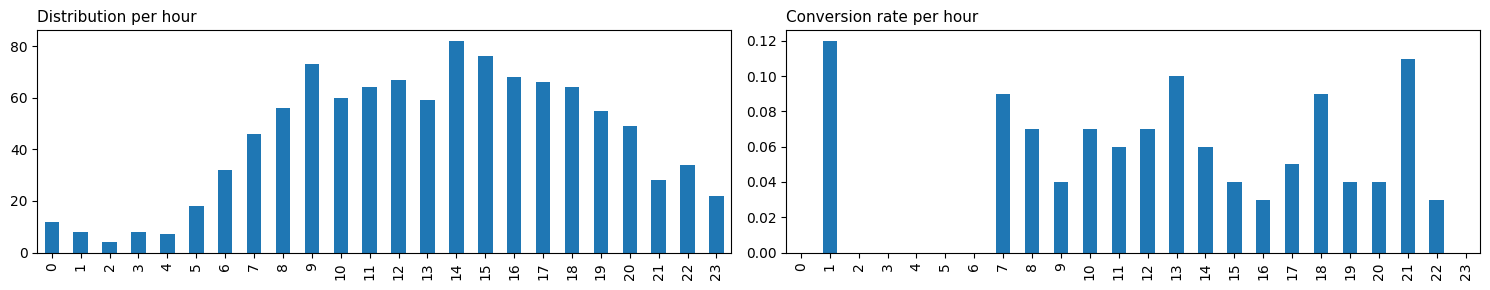

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
ax[0].set_title('Distribution per hour' , fontsize = 11, loc = 'left')
quotes['submitted_at_hour'].value_counts().sort_index().plot.bar(ax=ax[0])
ax[1].set_title('Conversion rate per hour' , fontsize = 11, loc = 'left')
quotes.groupby('submitted_at_hour')['has_subscribed'].mean().round(2).plot.bar(ax=ax[1])
for ax in ax:
    ax.set(xlabel='', ylabel='')
fig.tight_layout()

- On peut voir qu'il y a un taux de conversion assez différent en fonction de l'heure de complétion du devis. Cela peut être une variable intéressante à priori.
- On peut observer des horaires de pic de conversion autour de 7h, 13h, 18h et 21h. 
- On pourra utiliser la variable brute ou éventuellement créer des plages horaires.

Summary statistics: 
count          1058
unique            5
top       afternoon
freq            329
Name: submission_time, dtype: object

Percentage of missing data: 0.0%

Percentage of each discrete values: 
afternoon    31.1
morning      28.3
luncthime    19.7
evening      12.6
night         8.4
Name: submission_time, dtype: float64



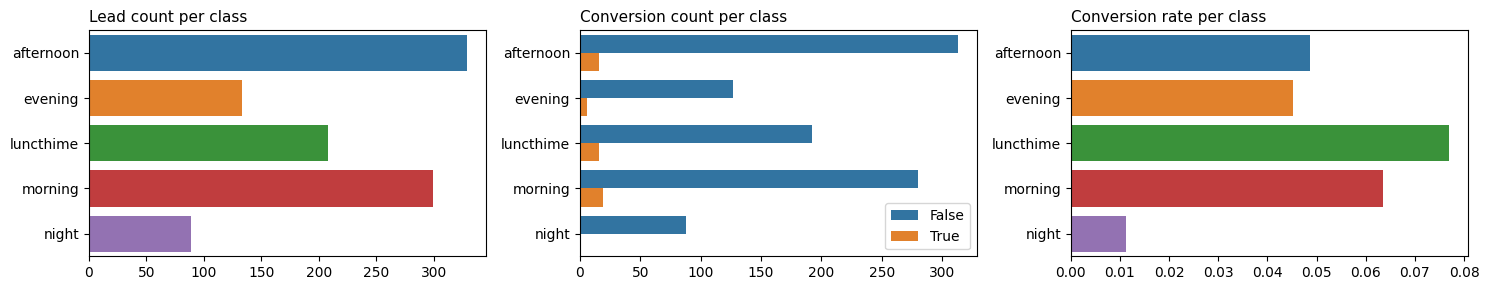

In [40]:
def time_class(hour):
    if hour in range(0,7):
        return 'night'
    elif hour in range(7,12):
        return 'morning'
    elif hour in range(12,15):
        return 'luncthime'
    elif hour in range(15,20):
        return 'afternoon'
    elif hour in range(20,24):
        return 'evening'


quotes['submission_time'] =  quotes['submitted_at_hour'].map(time_class)
cat_feature_analysis(quotes, 'submission_time')

---

## effective_start_date

Date de début souhaitée du contrat

In [41]:
quotes[quotes['effective_start_date'].isnull()]

long_quote_id              lead_id last_utm_source  \
984  8498856632564529598  3962607465724466504          google   

     has_been_proposed_formulas  has_chosen_formula  has_subscribed_online  \
984                       False               False                  False   

                 submitted_at effective_start_date rbs_result provider  ...  \
984 2021-09-01 13:26:00+02:00                  NaT        NaN      NaN  ...   

    vehicle_group vehicle_region has_secondary_driver has_subscribed  \
984           35+  Ile-De-France                False          False   

    negative_quote_id negative_lead_id nb_submitted_quotes  \
984                 1                1                   1   

    has_multiple_quotes submitted_at_hour  submission_time  
984               False                13        luncthime  

[1 rows x 37 columns]

In [42]:
quotes['effective_start_date'].max()

Timestamp('2021-12-02 00:00:00')

Les dates sont dans un range de 3 mois après la date de complétion du devis. Il peut-être interessant de regarder la distance en jours par rapport à la date de complétion du devis pour voir avec quelle urgence le prospect souhaite s'assurer.

In [43]:
quotes['delay_start_date_days'] = (quotes['effective_start_date'].dt.date  - quotes['submitted_at'].dt.date).dt.days
quotes['delay_start_date_weeks'] = quotes['delay_start_date_days'].apply(lambda x : int(x/7) if pd.notnull(x) else 0)

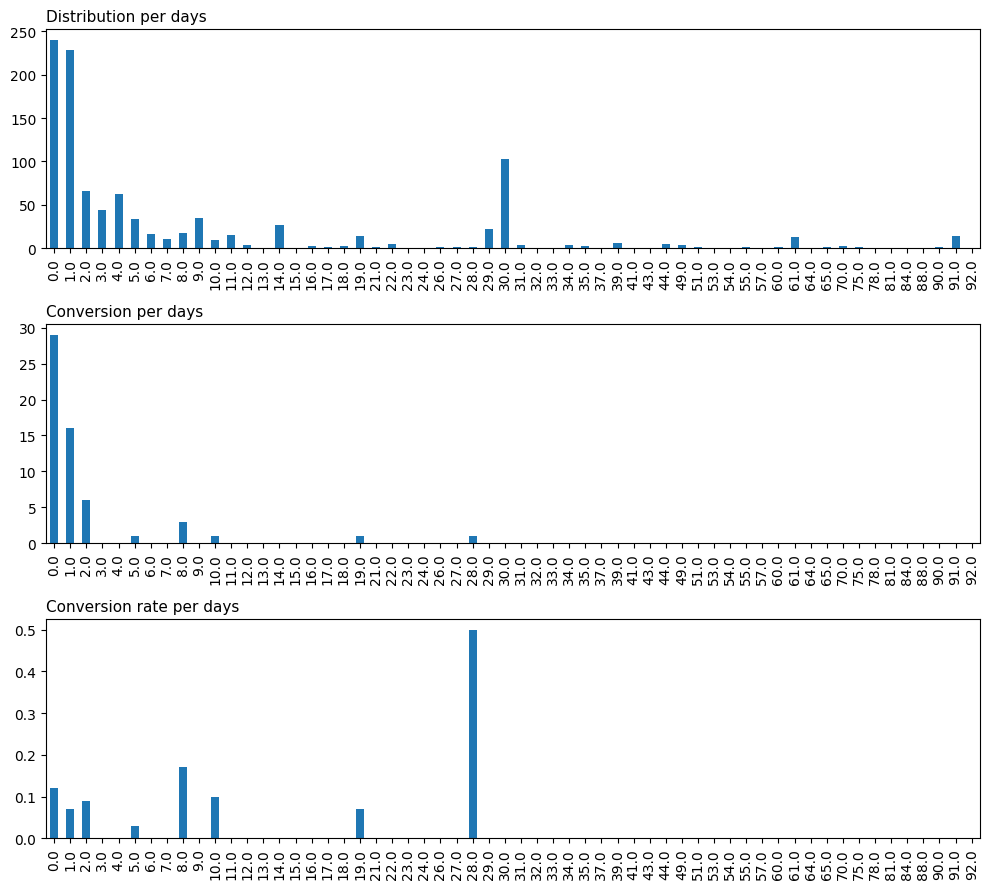

In [44]:
fig, ax = plt.subplots(3, 1, figsize=(10, 9))
ax[0].set_title('Distribution per days' , fontsize = 11, loc = 'left')
quotes['delay_start_date_days'].value_counts().sort_index().plot.bar(ax=ax[0])
ax[1].set_title('Conversion per days' , fontsize = 11, loc = 'left')
quotes.groupby('delay_start_date_days')['has_subscribed'].sum().plot.bar(ax=ax[1])
ax[2].set_title('Conversion rate per days' , fontsize = 11, loc = 'left')
quotes.groupby('delay_start_date_days')['has_subscribed'].mean().round(2).plot.bar(ax=ax[2])
for ax in ax:
    ax.set(xlabel='', ylabel='')
fig.tight_layout()

- On peut voir un pic enorme de conversion à 28 jours mais il n'y a que 2 cas ce jour là.
- Il y a également un pic au jour 8 sûrement lié au délai de retractation.
- On trouve ensuite logiquement des pics sur les 3 premiers jours.
- Au dela de 28 jours, la conversion est nulle

Summary statistics: 
count     1058
unique       7
top       00.0
freq       240
Name: delay_start_class, dtype: object

Percentage of missing data: 0.0%

Percentage of each discrete values: 
00.0     22.7
01.0     21.6
29+      19.7
03-07    15.9
08-14    10.4
02.0      6.2
15-28     3.6
Name: delay_start_class, dtype: float64



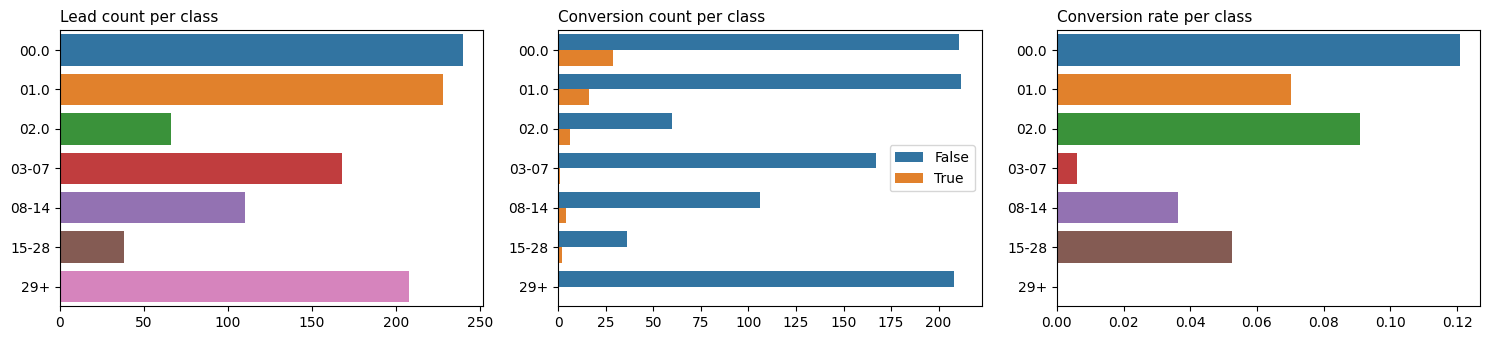

In [125]:
def delay_class(day):
    if day in range(0,3):
        return '0'+ str(day)
    elif day in range(3,8):
        return '03-07'
    elif day in range(8,15):
        return '08-14'
    elif day in range(15,29):
        return '15-28'
    else:
        return '29+'

quotes['delay_start_class'] =  quotes['delay_start_date_days'].map(delay_class)
cat_feature_analysis(quotes, 'delay_start_class')

---

### policy_subscribed_at

Date de souscription de la police

In [46]:
quotes['policy_subscribed_at'].notnull().sum()

22

On dispose d'une date de souscription seulement pour les contrats souscrits en ligne. Cette variable n'apporte à priori aucune information.

---

## Variables binaires


---

In [47]:
binary_features = [col for col in quotes.columns if quotes[col].nunique()==2 and col not in ['has_subscribed','has_subscribed_online']]
binary_features

['has_been_proposed_formulas',
 'has_chosen_formula',
 'provider',
 'main_driver_gender',
 'has_secondary_driver',
 'negative_quote_id',
 'negative_lead_id',
 'has_multiple_quotes']

### has_been_proposed_formulas

Si Ornikar a proposé d’assurer le lead

In [48]:
quotes['has_been_proposed_formulas'].isnull().sum()

0

In [49]:
quotes['has_been_proposed_formulas'].value_counts()/quotes.shape[0]

True     0.855388
False    0.144612
Name: has_been_proposed_formulas, dtype: float64

In [50]:
quotes.groupby('has_been_proposed_formulas')['has_subscribed'].mean()

has_been_proposed_formulas
False    0.039216
True     0.057459
Name: has_subscribed, dtype: float64

In [51]:
quotes.groupby('has_been_proposed_formulas')['has_subscribed_online'].mean()

has_been_proposed_formulas
False    0.000000
True     0.018785
Name: has_subscribed_online, dtype: float64

- 14% des leads n'ont pas eu de proposition. Ces cas ont un taux de conversion inférieur aux leads qui ont eu une proposition. 
- Aucun d'entre eux n'a souscrit en ligne. 
- S'agit-il de leads pour qui un devis en ligne n'était pas faisable et ont du parler au service client?

---

### has_chosen_formula

si le lead a cliqué la formule proposée

In [52]:
quotes['has_chosen_formula'].isnull().sum()

0

In [53]:
quotes['has_chosen_formula'].value_counts()/quotes.shape[0]

False    0.767486
True     0.232514
Name: has_chosen_formula, dtype: float64

In [54]:
quotes.groupby('has_chosen_formula')['has_subscribed'].mean()

has_chosen_formula
False    0.030788
True     0.134146
Name: has_subscribed, dtype: float64

In [55]:
quotes.groupby('has_chosen_formula')['has_subscribed_online'].mean()

has_chosen_formula
False    0.000000
True     0.069106
Name: has_subscribed_online, dtype: float64

Si le lead clique sur la formule proposée, le taux de conversion est 4 fois plus elevé mais il y a tout de même un taux de 3% de souscription hors-ligne pour ceux qui ne valident pas la formule proposée.

---

### provider

Fournisseur de contrat d’assurance

In [56]:
quotes['provider'] = quotes['provider'].fillna('missing')

In [57]:
quotes['provider'].value_counts()/quotes.shape[0]

provider_A    0.623819
provider_B    0.231569
missing       0.144612
Name: provider, dtype: float64

In [58]:
quotes.groupby('provider')['has_subscribed'].mean()

provider
missing       0.039216
provider_A    0.077273
provider_B    0.004082
Name: has_subscribed, dtype: float64

In [59]:
quotes.groupby('provider')['has_subscribed_online'].mean()

provider
missing       0.000000
provider_A    0.025758
provider_B    0.000000
Name: has_subscribed_online, dtype: float64

In [60]:
quotes['has_subscribed'].mean()

0.054820415879017016

Il y a deux fournisseurs d'assurance (selon les formules j'imagine). 
- 62% des devis concernent le provider A
- 23% des devis concernent le provider B
- 14% des devis n'ont pas de provider mentionné

Le taux de conversion est supérieur à la moyenne pour le provider A, quasi nul pour le provider B et légèrement sous la moyenne pour les cas sans provider.

Seul les lead avec fournisseur A ont une conversion en ligne.

---

### main_driver_gender

Genre du lead

In [61]:
quotes['main_driver_gender'].isnull().sum()

0

In [62]:
quotes['main_driver_gender'].value_counts()/quotes.shape[0]

M    0.636106
F    0.363894
Name: main_driver_gender, dtype: float64

In [63]:
quotes.groupby('main_driver_gender')['has_subscribed'].mean()

main_driver_gender
F    0.057143
M    0.053492
Name: has_subscribed, dtype: float64

In [64]:
quotes.groupby('main_driver_gender')['has_subscribed_online'].mean()

main_driver_gender
F    0.015584
M    0.016345
Name: has_subscribed_online, dtype: float64

Les deux tiers des leads sont des hommes. Les taux de conversion sont assez similaires entre hommes et femmes.

---

### has_secondary_driver

Si le devis inclut un conducteur secondaire

In [65]:
quotes['has_secondary_driver'].isnull().sum()

0

In [66]:
quotes['has_secondary_driver'].value_counts()/quotes.shape[0]

False    0.869565
True     0.130435
Name: has_secondary_driver, dtype: float64

In [67]:
quotes.groupby('has_secondary_driver')['has_subscribed'].mean()

has_secondary_driver
False    0.053261
True     0.065217
Name: has_subscribed, dtype: float64

In [68]:
quotes.groupby('has_secondary_driver')['has_subscribed_online'].mean()

has_secondary_driver
False    0.016304
True     0.014493
Name: has_subscribed_online, dtype: float64

La grande majorité des leads n'inclut pas de conducteur secondaire. Le taux de conversion global est légerement supérieur lorsqu'il y a un second conducteur.

---

### negative_quote_id

In [69]:
quotes['negative_quote_id'].isnull().sum()

0

In [70]:
quotes['negative_quote_id'].value_counts()/quotes.shape[0]

1    0.52741
0    0.47259
Name: negative_quote_id, dtype: float64

In [71]:
quotes.groupby('negative_quote_id')['has_subscribed'].mean()

negative_quote_id
0    0.05000
1    0.05914
Name: has_subscribed, dtype: float64

In [72]:
quotes.groupby('negative_quote_id')['has_subscribed_online'].mean()

negative_quote_id
0    0.020000
1    0.012545
Name: has_subscribed_online, dtype: float64

Difficile de savoir si cette variable contient une réelle information. 

Néanmoins, on peut constater que:
- le taux de conversion global est plus élevé pour les cas dont le quote_id commence par un signe `-`
- le taux de conversion en ligne est plus élevé pour les cas dont le quote_id ne commence pas par un signe `-`

---

### negative_lead_id

In [73]:
quotes['negative_lead_id'].isnull().sum()

0

In [74]:
quotes['negative_lead_id'].value_counts()/quotes.shape[0]

1    0.513233
0    0.486767
Name: negative_lead_id, dtype: float64

In [75]:
quotes.groupby('negative_lead_id')['has_subscribed'].mean()

negative_lead_id
0    0.050485
1    0.058932
Name: has_subscribed, dtype: float64

In [76]:
quotes.groupby('negative_lead_id')['has_subscribed_online'].mean()

negative_lead_id
0    0.009709
1    0.022099
Name: has_subscribed_online, dtype: float64

Difficile aussi de savoir si cette variable contient une réelle information. 

Néanmoins, on peut constater que:
- le taux de conversion global est plus élevé pour les cas dont le quote_id commence par un signe `-`
- le taux de conversion en ligne est quasi nul pour les cas dont le lead_id ne commence pas par un signe `-`

---

### Variables de catégorie à 3 classes

---

In [77]:
cat_3_features = [col for col in quotes.columns if quotes[col].nunique()==3]
cat_3_features

['rbs_result',
 'provider',
 'annual_price_third_party',
 'annual_price_intermediate',
 'annual_price_all_risks',
 'chosen_formula']

### rbs_result

Résultat du test psychologique qui est proposé aux jeunes conducteurs

Summary statistics: 
count           42
unique           3
top       rejected
freq            20
Name: rbs_result, dtype: object

Percentage of missing data: 96.03024574669186%

Conversion rate - missing data:  0.04

Conversion rate - non-missing:  0.36

Percentage of each discrete values: 
rejected        47.6
accepted        31.0
needs device    21.4
Name: rbs_result, dtype: float64



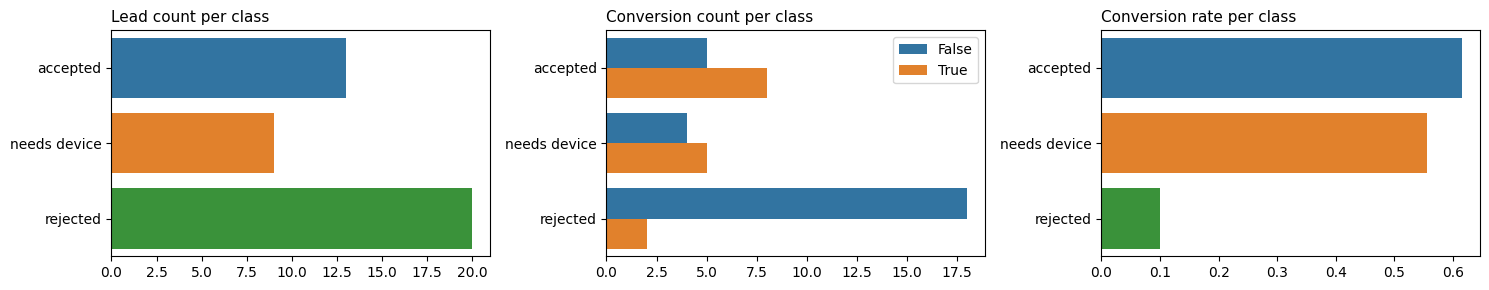

In [78]:
cat_feature_analysis(quotes, 'rbs_result')

Moins de 4% des prospect passent le test. Néanmoins, pour ceux qui le passent, le taux de conversion est supérieur à la moyenne. Il est même très élevé lorsque le résultat est `accepted` ou `needs device`.

Vu le nombre faible d'observations, on pourrait éventuellement regrouper les `accepted` et `needs device`

---

### annual_price_third_party

niveau de prix au tiers proposé

Summary statistics: 
count     905
unique      3
top       low
freq      383
Name: annual_price_third_party, dtype: object

Percentage of missing data: 14.46124763705104%

Conversion rate - missing data:  0.04

Conversion rate - non-missing:  0.06

Percentage of each discrete values: 
low        36.2
medium     33.0
high       16.4
missing    14.5
Name: annual_price_third_party, dtype: float64



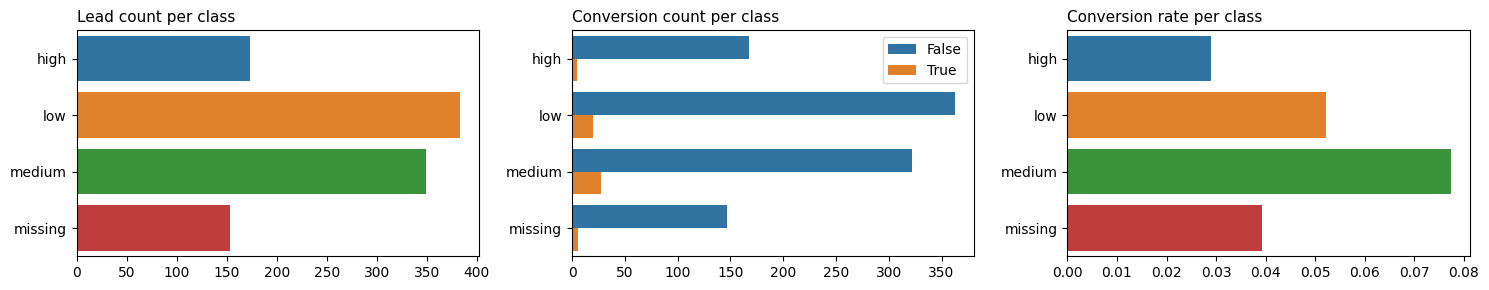

In [79]:
cat_feature_analysis(quotes, 'annual_price_third_party', missing_class=True)

- Le prix au tiers n'est pas proposé dans 14% des cas.
- Le taux de conversion est moyen lorsque le prix n'est pas proposé ou lorsque le prix est dans la tranche `low`
- Le taux de conversion est supérieur à la moyenne pour la tranche de prix `medium` et inférieux à la moyenne pour la tranche de prix `high`

---

### annual_price_intermediate

niveau de prix intermédiaire proposé

Summary statistics: 
count        905
unique         3
top       medium
freq         319
Name: annual_price_intermediate, dtype: object

Percentage of missing data: 14.46124763705104%

Conversion rate - missing data:  0.04

Conversion rate - non-missing:  0.06

Percentage of each discrete values: 
medium     30.2
low        28.7
high       26.7
missing    14.5
Name: annual_price_intermediate, dtype: float64



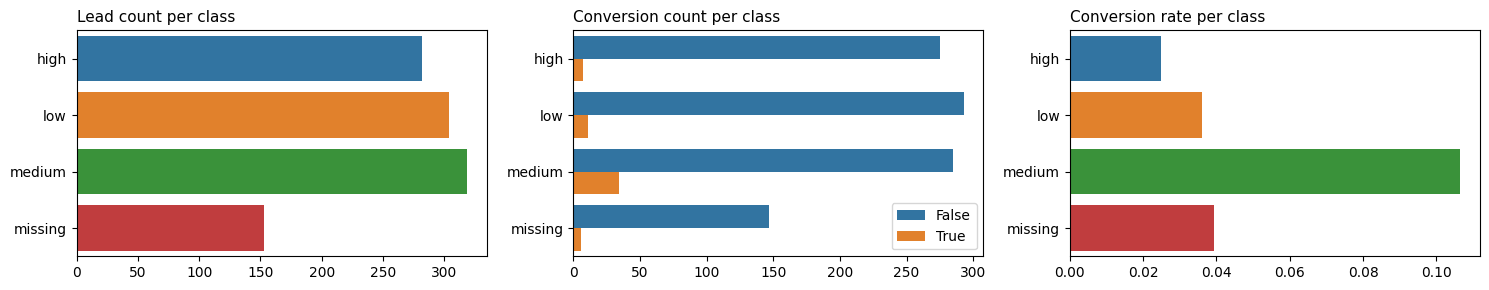

In [80]:
cat_feature_analysis(quotes, 'annual_price_intermediate', missing_class = True)

- Le prix de la formulaire intermediaire n'est pas proposé dans 14% des cas.
- Le taux de conversion est légérement inférieur à la moyenne lorsque le prix n'est pas proposé et pour la tranche `low`
- Le taux de conversion est nettement supérieur à la moyenne pour la tranche de prix `medium` et nettement inférieur à la moyenne pour la tranche de prix `high` 

---

### annual_price_all_risks

niveau de prix tous risques proposé

Summary statistics: 
count        900
unique         3
top       medium
freq         374
Name: annual_price_all_risks, dtype: object

Percentage of missing data: 14.933837429111533%

Conversion rate - missing data:  0.04

Conversion rate - non-missing:  0.06

Percentage of each discrete values: 
medium     35.3
low        27.4
high       22.3
missing    14.9
Name: annual_price_all_risks, dtype: float64



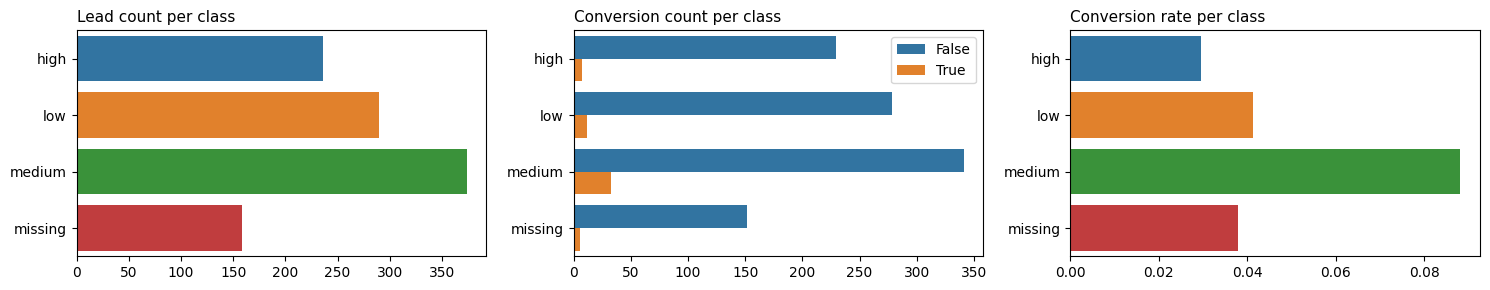

In [81]:
cat_feature_analysis(quotes, 'annual_price_all_risks', missing_class=True)

- Le prix de la formule tous risques n'est pas proposé dans 15% des cas.
- Le taux de conversion est légérement inférieur à la moyenne lorsque le prix n'est pas proposé et pour la tranche `low`
- Le taux de conversion est nettement supérieur à la moyenne pour la tranche de prix `medium` et nettement inférieur à la moyenne pour la tranche de prix `high` 

---

### chosen_formula

Summary statistics: 
count             246
unique              3
top       third party
freq              115
Name: chosen_formula, dtype: object

Percentage of missing data: 76.74858223062382%

Conversion rate - missing data:  0.03

Conversion rate - non-missing:  0.13

Percentage of each discrete values: 
third party     46.7
all risks       27.6
intermediate    25.6
Name: chosen_formula, dtype: float64



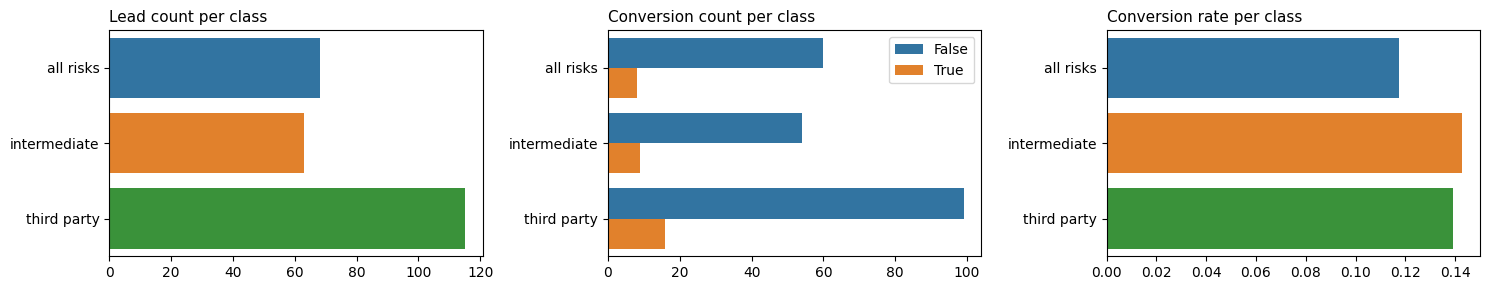

In [82]:
cat_feature_analysis(quotes, 'chosen_formula')

- 77% des prospects ne choisissent pas de formule
- Pour ceux qui la choisissent :
    * 46% choisissent la formule au tiers
    * 27% la forumule tous risque
    * 25% la formule intermédiaire

Néanmoins, pour ceux qui choisissent une formule, le taux de conversion est très supérieur à la moyenne. La formule intermediate est la formule qui convertit le mieux.

---

## Variables de catégorie à 6 ou 7 classes

---

In [83]:
cat_6_features = [col for col in quotes.columns if quotes[col].nunique() in (6,7)]
cat_6_features

['main_driver_age',
 'main_driver_licence_age',
 'main_driver_bonus',
 'vehicle_age',
 'vehicle_class',
 'vehicle_group',
 'nb_submitted_quotes',
 'delay_start_class']

### main_driver_age

age du lead

Summary statistics: 
count      1058
unique        6
top       18-20
freq        293
Name: main_driver_age, dtype: object

Percentage of missing data: 0.0%

Percentage of each discrete values: 
18-20    27.7
21-24    22.0
25-29    17.5
40-59    15.0
30-39    14.0
60+       3.8
Name: main_driver_age, dtype: float64



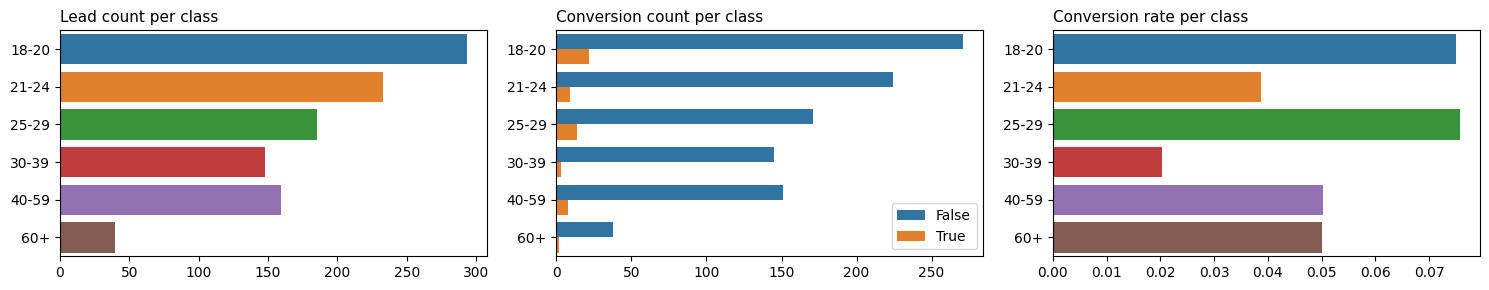

In [84]:
cat_feature_analysis(quotes, 'main_driver_age')

- Les leads sont majoritairement jeunes. La moitié ont moins de 24 ans et les 3/4 ont moins de 29. 
- Le taux de conversion est supérieur à la moyenne sur les 18-20 et les 25-29.
- Le taux est moyen sur les 40+
- Le taux est inférieur à la moyenne sur les 21-24 et très bas sur les 30-39.

On devrait pouvoir rassembler les classes 40-59 et 60+ en une seule classe.

Summary statistics: 
count      1058
unique        5
top       18-20
freq        293
Name: main_driver_age, dtype: object

Percentage of missing data: 0.0%

Percentage of each discrete values: 
18-20    27.7
21-24    22.0
40+      18.8
25-29    17.5
30-39    14.0
Name: main_driver_age, dtype: float64



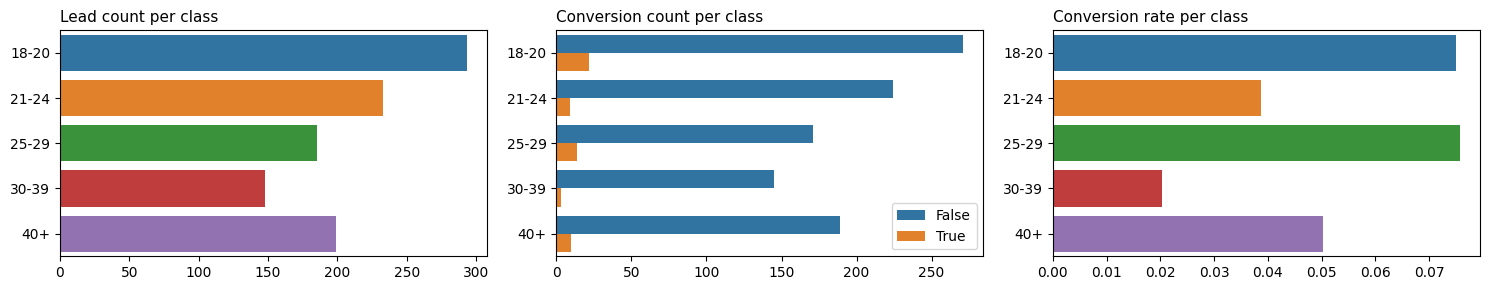

In [85]:
quotes.loc[quotes['main_driver_age'].isin(['40-59','60+']),'main_driver_age']='40+'
cat_feature_analysis(quotes, 'main_driver_age')

---

### main_driver_licence_age

ancienneté du permis du lead

Summary statistics: 
count     1058
unique       6
top         00
freq       358
Name: main_driver_licence_age, dtype: object

Percentage of missing data: 0.0%

Percentage of each discrete values: 
00       33.8
15+      19.2
03-06    18.1
07-14    13.2
01        8.9
02        6.7
Name: main_driver_licence_age, dtype: float64



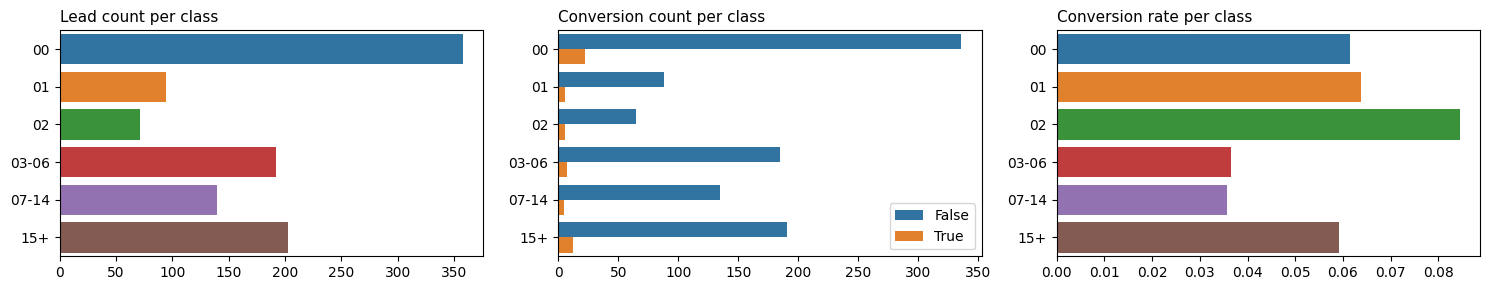

In [86]:
cat_feature_analysis(quotes, 'main_driver_licence_age')

- Un tiers des leads sont des nouveaux conducteurs, un tiers ont entre 1 et 6 ans et un tiers ont plus de 7 ans de permis.
- Le taux de conversion est particulièrement élevé pour les lead avec 2 ans de permis.
- Le taux est légèrement au dessus de la moyenne pour les conducteurs avec 1 an ou moins de permis et 15 ans ou plus.
- Le taux est assez bas pour les leads entre 3 et 14 ans de permis.

Pour simplifier cette variable, on pourrait regrouper les classes 0 et 1 ainsi que les classes 3-6 et 7-14

Summary statistics: 
count      1058
unique        4
top       00-01
freq        452
Name: main_driver_licence_age, dtype: object

Percentage of missing data: 0.0%

Percentage of each discrete values: 
00-01    42.7
03-14    31.4
15+      19.2
02        6.7
Name: main_driver_licence_age, dtype: float64



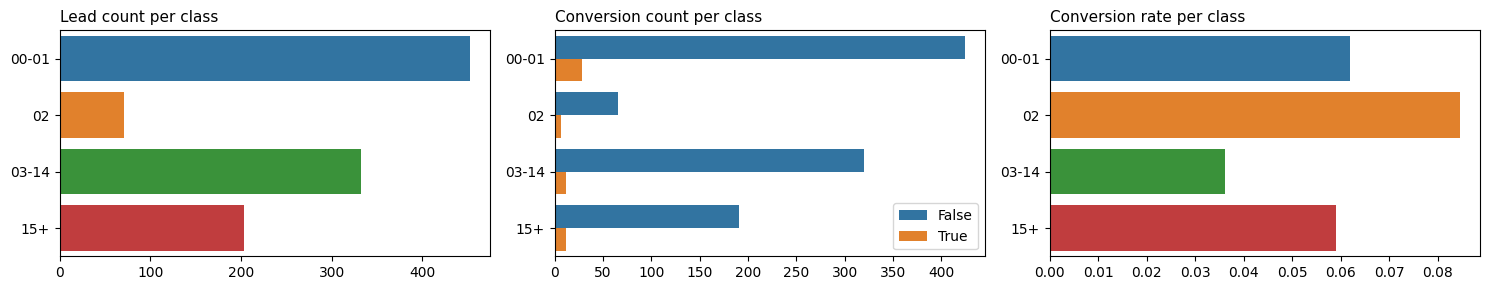

In [87]:
quotes.loc[quotes['main_driver_licence_age'].isin(['00','01']),'main_driver_licence_age']='00-01'
quotes.loc[quotes['main_driver_licence_age'].isin(['03-06','07-14']),'main_driver_licence_age']='03-14'
cat_feature_analysis(quotes, 'main_driver_licence_age')

---

### main_driver_bonus

Catégorie de bonus/malus du lead

Summary statistics: 
count     1058
unique       6
top        100
freq       636
Name: main_driver_bonus, dtype: object

Percentage of missing data: 0.0%

Percentage of each discrete values: 
100        60.1
050        12.6
085-099    12.2
064-084     8.5
101+        3.5
051-063     3.1
Name: main_driver_bonus, dtype: float64



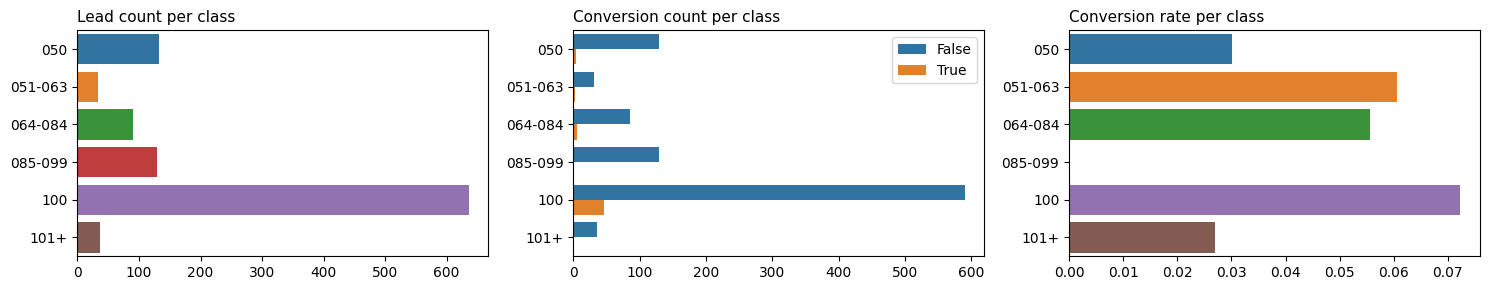

In [88]:
cat_feature_analysis(quotes, 'main_driver_bonus')

- 60% des leads ont un taux de base (logique étant donné que la majorité sont des jeunes conducteurs). 37% sont en bonus dont un tiers en bonus maximal. Enfin 3% sont en malus.
- Le taux de conversion est le plus elevé pour les taux à 1 (jeunes conducteurs). Il est aussi supérieur à la moyenne pour les bonus entre 51 et 84.
- Le taux est bas pour les lead en malus ou en bonus maximal.
- Enfin le taux de conversion est nul pour les bonus légers entre 85 et 99.

On pourrait éventuellement regrouper les classes 051-063 et 064-084.

Summary statistics: 
count     1058
unique       5
top        100
freq       636
Name: main_driver_bonus, dtype: object

Percentage of missing data: 0.0%

Percentage of each discrete values: 
100        60.1
050        12.6
085-099    12.2
051-084    11.6
101+        3.5
Name: main_driver_bonus, dtype: float64



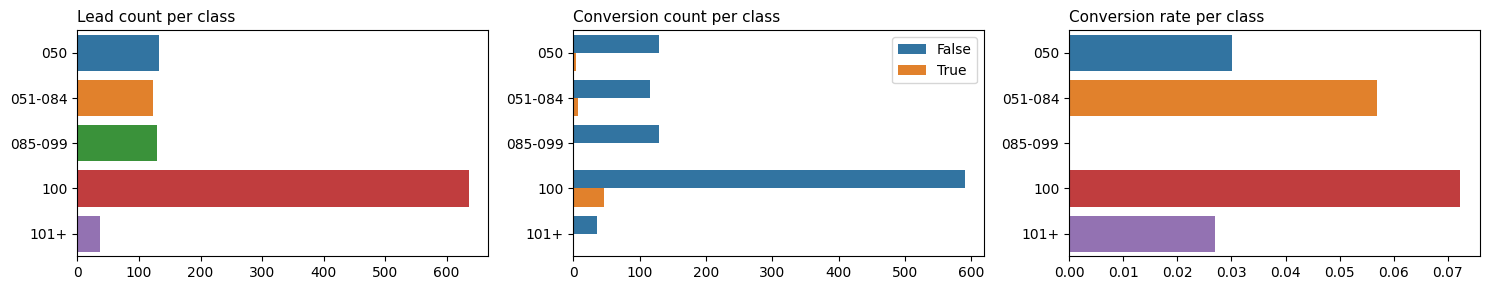

In [89]:
quotes.loc[quotes['main_driver_bonus'].isin(['051-063','064-084']),'main_driver_bonus']='051-084'
cat_feature_analysis(quotes, 'main_driver_bonus')

---

### vehicle_age

Catégorie d’ancienneté du véhicule du lead

Summary statistics: 
count      1058
unique        7
top       10-14
freq        322
Name: vehicle_age, dtype: object

Percentage of missing data: 0.0%

Percentage of each discrete values: 
10-14    30.4
15-19    23.4
06-09    15.7
03-05    12.2
20+      10.6
00        3.9
01-02     3.8
Name: vehicle_age, dtype: float64



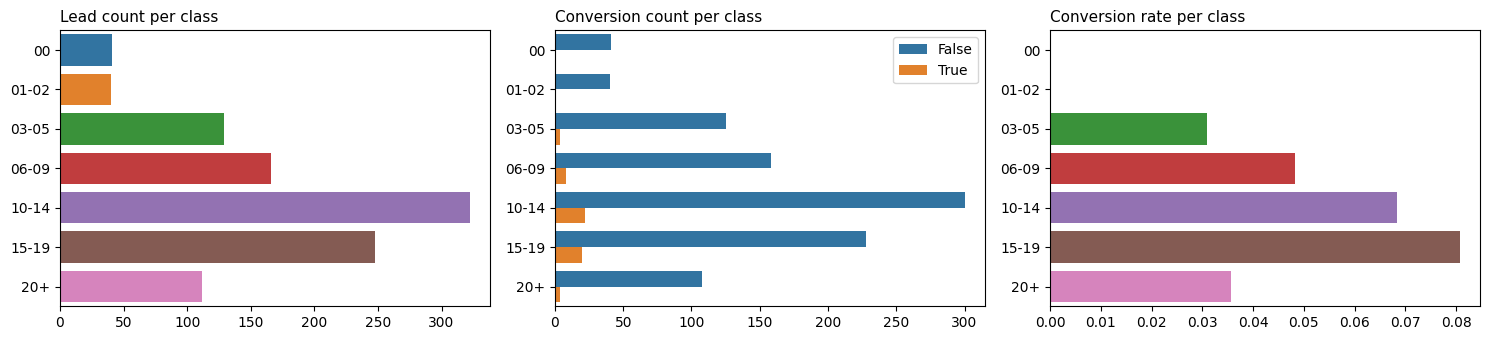

In [90]:
cat_feature_analysis(quotes, 'vehicle_age')

- Plus de la moitié des véhicules ont entre 10 et 19 ans, ce qui est plutôt logique pour des jeunes conducteurs. Un tiers des véhicules a entre 3 et 9 ans. 8% ont moins de 3 ans et 10% ont plus de 20 ans.
- Le taux de conversion est élevé pour les véhicules entre 10 et 19 ans.
- Le taux est moyen pour les véhicules entre 6 et 9 ans.
- Le taux est bas pour les véhicules très ancien (20+) et assez récent (3-5 ans)
- Enfin le taux de conversion est nul pour les véhicules de moins de 3 ans (l'offre étant probablement dissuasive ou non adaptée).
                                                                            
On pourrait simplifier la variable en regroupant les classes '00' et '01-02' et éventuellement les classes '10-14' et '15-19'.                                                                      

Summary statistics: 
count      1058
unique        5
top       10-19
freq        570
Name: vehicle_age, dtype: object

Percentage of missing data: 0.0%

Percentage of each discrete values: 
10-19    53.9
06-09    15.7
03-05    12.2
20+      10.6
00-02     7.7
Name: vehicle_age, dtype: float64



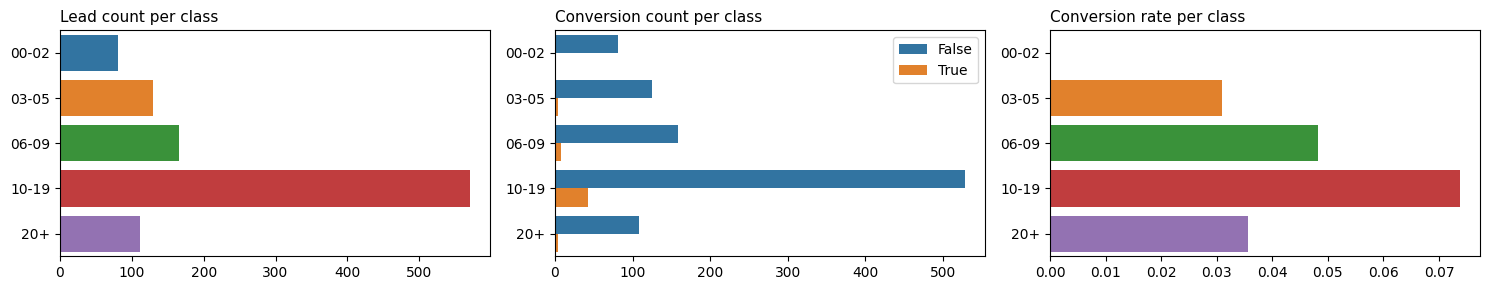

In [91]:
quotes.loc[quotes['vehicle_age'].isin(['00','01-02']),'vehicle_age']='00-02'
quotes.loc[quotes['vehicle_age'].isin(['10-14','15-19']),'vehicle_age']='10-19'
cat_feature_analysis(quotes, 'vehicle_age')

---

### vehicle_class

Catégorie de classe du véhicule du lead

Cette classe correspond probablement à la classe de prix SRA du véhicule.

Notée de A à V (A = faible valeur, V = forte), elle est établie par la valeur à neuf TTC du véhicule (hors option, hors remise). 

Elle est utile à l’assureur en cas de vol ou de remplacement d’un véhicule suite à un sinistre.

Summary statistics: 
count     1043
unique       7
top        I-K
freq       371
Name: vehicle_class, dtype: object

Percentage of missing data: 1.4177693761814745%

Conversion rate - missing data:  0.0

Conversion rate - non-missing:  0.06

Percentage of each discrete values: 
I-K        35.1
F-H        25.6
L-N        21.0
A-E         8.2
O-R         7.7
missing     1.4
S-T         0.9
U+          0.1
Name: vehicle_class, dtype: float64



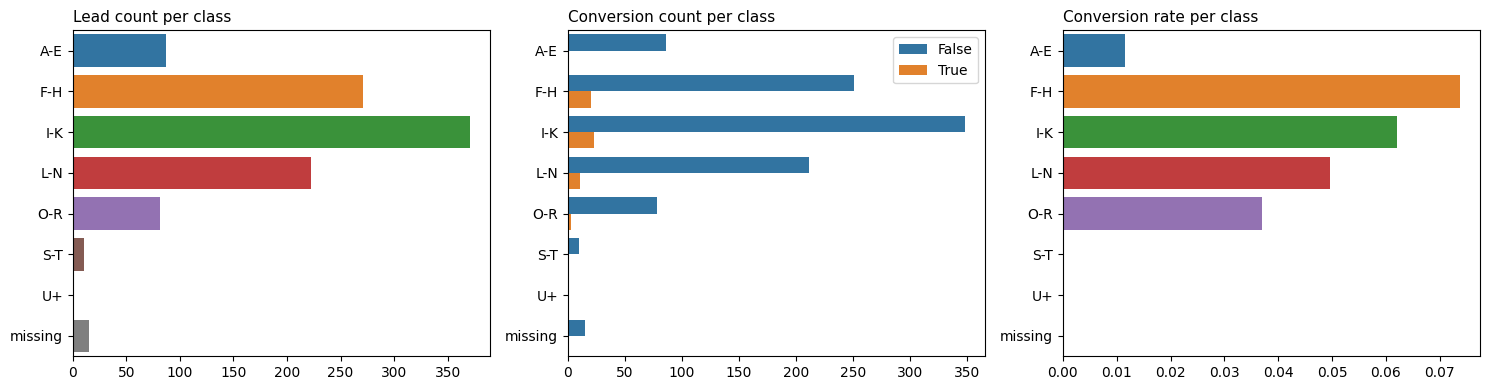

In [92]:
cat_feature_analysis(quotes, 'vehicle_class', missing_class = True)

- 60% des véhicules sont de valeur basse (I-K) ou moyenne basse (F-H). 21% sont de valeur moyenne (L-N). 8% sont de valeurs moyenne haute (O-R) et 8% de valeurs très basse. Enfin 1% sont de haute valeurs.
- Le taux de conversion est très bas pour les véhicules à très faible valeur.
- Le taux est le plus elevé sur les véhicules de valeurs basses (F-H) et décroit ensuite de manières assez linéaire jusqu'a la classe 0-R (moyenne haute).
- Le taux est nul pour les classes S+
- Il y a 1.5% de données manquantes avec un taux de conversion nul


On peut regrouper les classes S-T et U+.

Summary statistics: 
count     1043
unique       6
top        I-K
freq       371
Name: vehicle_class, dtype: object

Percentage of missing data: 1.4177693761814745%

Conversion rate - missing data:  0.0

Conversion rate - non-missing:  0.06

Percentage of each discrete values: 
I-K        35.1
F-H        25.6
L-N        21.0
A-E         8.2
O-R         7.7
missing     1.4
S+          1.0
Name: vehicle_class, dtype: float64



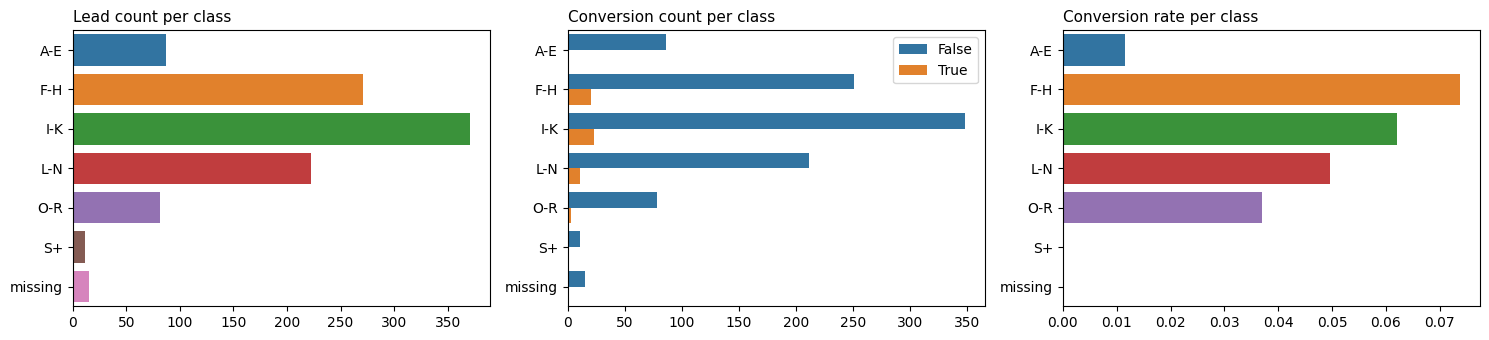

In [93]:
quotes.loc[quotes['vehicle_class'].isin(['S-T','U+']),'vehicle_class']='S+'
cat_feature_analysis(quotes, 'vehicle_class', missing_class = True)

---

### vehicle_group

Catégorie de groupe du véhicule du lead

Noté de 20 à 50, le groupe représente la puissance de l’automobile (20 = faible puissance, 50 = forte puissance), mais également sa dangerosité.

Il permet notamment à l’assureur d’établir le tarif de la responsabilité civile obligatoire (en raison des dommages que peut infliger un véhicule de puissance supérieure).

Summary statistics: 
count      1043
unique        6
top       29-30
freq        370
Name: vehicle_group, dtype: object

Percentage of missing data: 1.4177693761814745%

Conversion rate - missing data:  0.0

Conversion rate - non-missing:  0.06

Percentage of each discrete values: 
29-30      35.0
31-32      26.2
27-28      17.8
33-34      13.5
35+         5.5
missing     1.4
20-26       0.7
Name: vehicle_group, dtype: float64



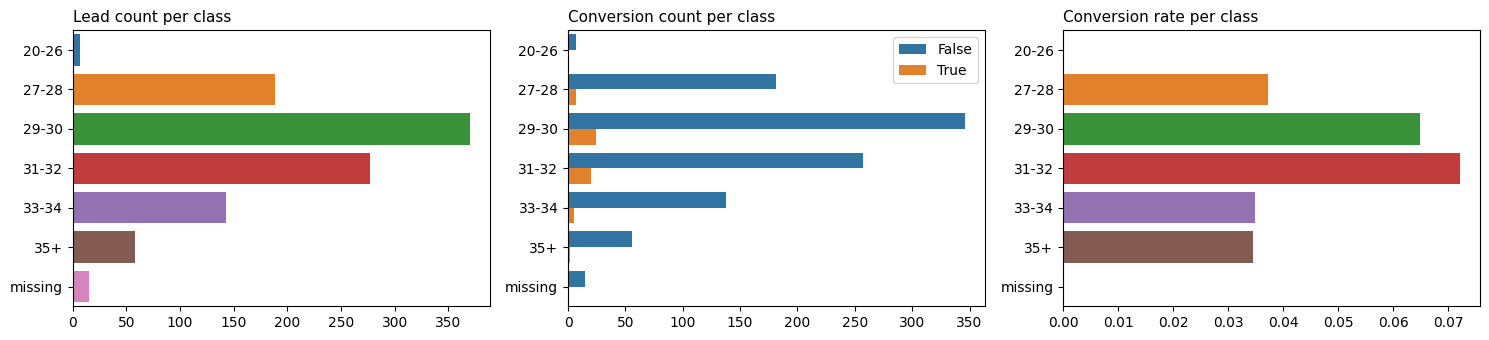

In [94]:
cat_feature_analysis(quotes, 'vehicle_group', missing_class = True)

- La distribution des groupes est de style gaussienne autour des groupes 29-30
- Le taux de conversion est élevé pour les groupes 29 à 32, bas pour les groupes 27-28 et 33+ et nul pour les groupes 20-26
- Il y a 1.5% de données manquantes avec un taux de conversion nul

On pourrait grouper les classes 33-34 et 35+. Vu le faible nb de cas sur la classe 20-26 on pourrait également la regrouper avec la classe 27-28.

Summary statistics: 
count      1043
unique        4
top       29-30
freq        370
Name: vehicle_group, dtype: object

Percentage of missing data: 1.4177693761814745%

Conversion rate - missing data:  0.0

Conversion rate - non-missing:  0.06

Percentage of each discrete values: 
29-30      35.0
31-32      26.2
33+        19.0
20-28      18.4
missing     1.4
Name: vehicle_group, dtype: float64



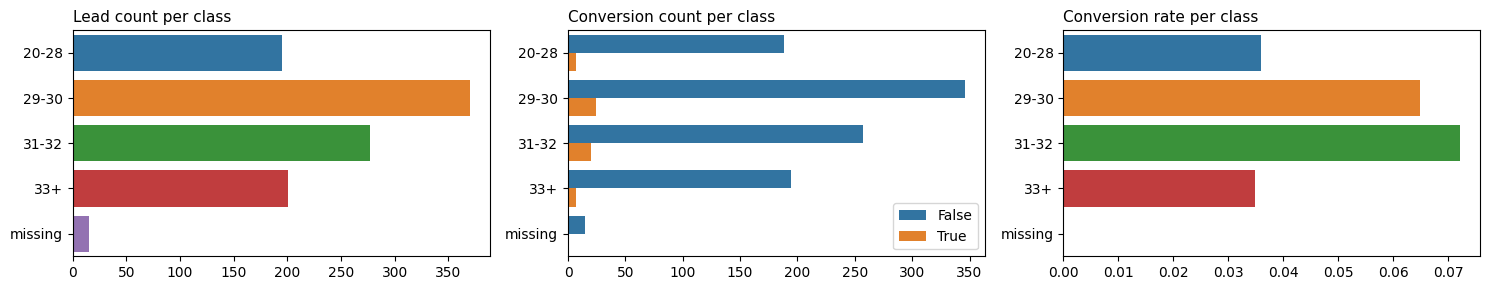

In [95]:
quotes.loc[quotes['vehicle_group'].isin(['33-34','35+']),'vehicle_group']='33+'
quotes.loc[quotes['vehicle_group'].isin(['20-26','27-28']),'vehicle_group']='20-28'
cat_feature_analysis(quotes, 'vehicle_group', missing_class = True)

---

## Variables de catégorie à plus de 10 classes

---

In [96]:
cat_10_features = [col for col in quotes.columns if quotes[col].nunique() > 10 and col not in date_col]
cat_10_features

['long_quote_id',
 'lead_id',
 'last_utm_source',
 'product_third_party',
 'product_intermediate',
 'product_all_risks',
 'chosen_product',
 'contract_id',
 'vehicle_region',
 'submitted_at_hour',
 'delay_start_date_days',
 'delay_start_date_weeks']

### last_utm_source

Dernière source d'acquisition du lead.

Les paramètres utm sont des balises que l’on rajoute dans les urls afin de suivre les sources d’acquisition du trafic sur un site Web.

Summary statistics: 
count          195
unique          12
top       facebook
freq            54
Name: last_utm_source, dtype: object

Percentage of missing data: 81.56899810964083%

Conversion rate - missing data:  0.04

Conversion rate - non-missing:  0.14

Percentage of each discrete values: 
missing            81.6
facebook            5.1
comparator_B        3.6
comparator_C        3.6
google              2.9
CRM                 0.9
ornikar.produit     0.8
blog.ornikar        0.5
comparator_A        0.4
snapchat            0.2
siteweb             0.2
ornikar             0.2
awin                0.1
Name: last_utm_source, dtype: float64



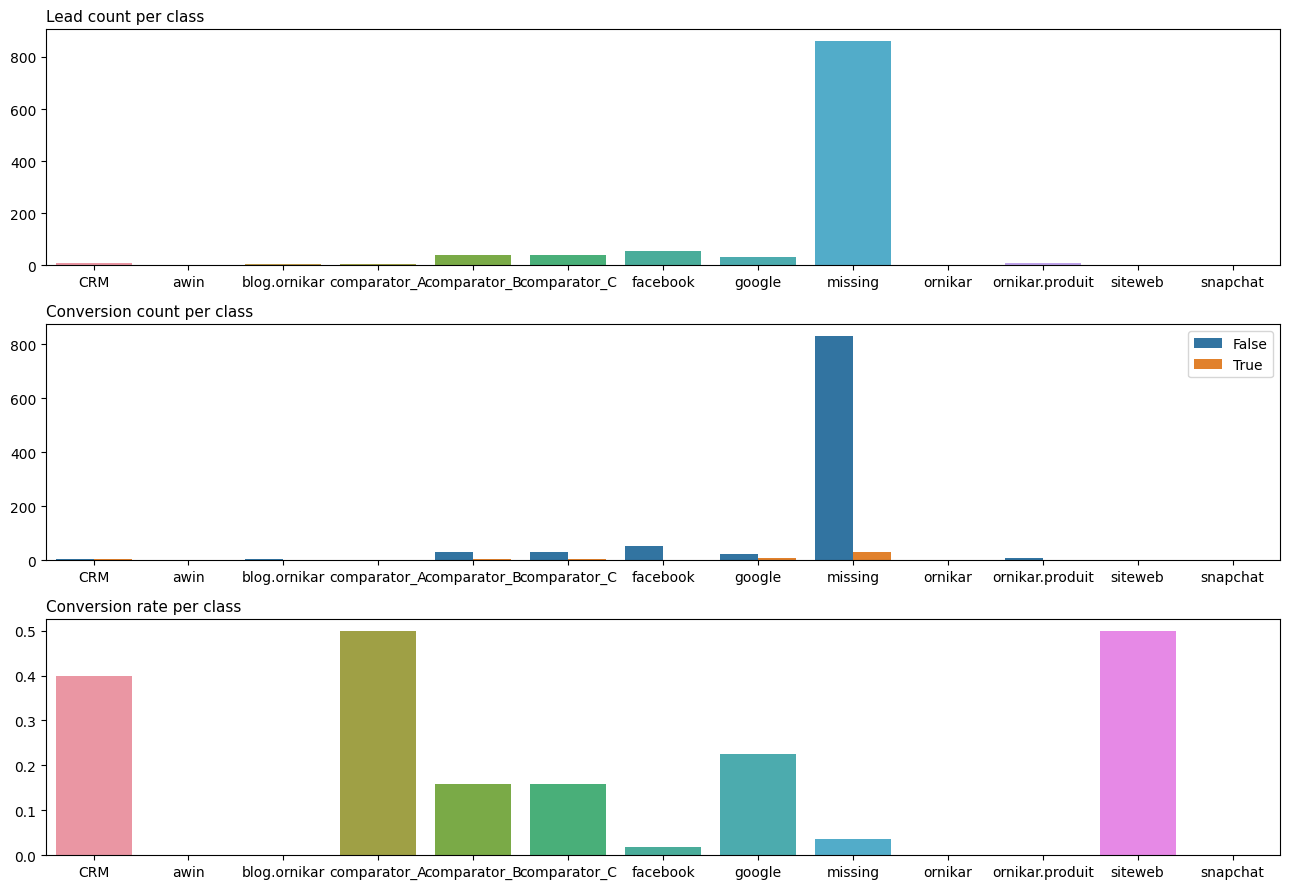

In [97]:
cat_feature_analysis_horizontal(quotes, 'last_utm_source',missing_class=True)

- 82% des leads n'ont pas de source utm
- 5 des leads viennent de facebook. Les comparateurs B et C ramènent chacun 3.6% de lead. 3% viennent de google et 1% de leads sont traitées via le CRM (service client). Le reste est négligeable.
- Le taux de conversion des leads facebook est très faible.
- Le taux de conversion des leads google est très bon (plus de 20%)
- Le taux des comparateurs B et C est aussi bon (plus de 15%)
- Le taux de conversion CRM est très élevé (sur seulement 10 cas) ce qui semble logique
- Les autres taux sont difficilement interpretable vu le faible nombre d'observations

On pourrait simplifier la segmentation de manière suivante:

- Facebook
- Google
- Comparateurs A,B,C
- CRM
- Autres catégories dans missing

Summary statistics: 
count             175
unique              4
top       comparators
freq               80
Name: last_utm_source, dtype: object

Percentage of missing data: 83.4593572778828%

Conversion rate - missing data:  0.04

Conversion rate - non-missing:  0.15

Percentage of each discrete values: 
missing        83.5
comparators     7.6
facebook        5.1
google          2.9
CRM             0.9
Name: last_utm_source, dtype: float64



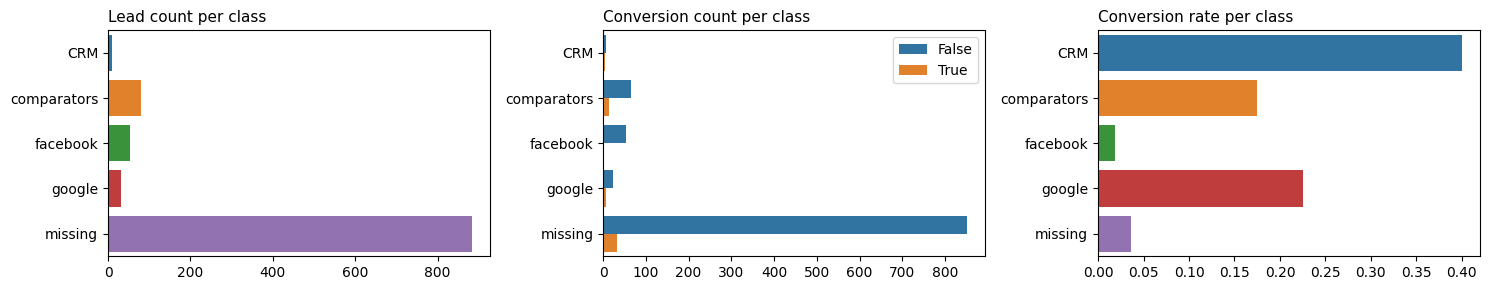

In [98]:
quotes.loc[quotes['last_utm_source'].isin(['awin','snapchat','blog.ornikar','ornikar','ornikar.produit','siteweb']),'last_utm_source']= np.NaN
quotes.loc[quotes['last_utm_source'].isin(['comparator_A','comparator_B','comparator_C']),'last_utm_source']='comparators'
cat_feature_analysis(quotes, 'last_utm_source', missing_class = True)

---

### product_third_party

Produit au tiers proposé

In [99]:
# Simplifions les noms de catégorie pour les graphiques
quotes['product_third_party'] = quotes['product_third_party'].str.replace('third_party_product','tp_prod')

Summary statistics: 
count           905
unique           28
top       tp_prod_4
freq            448
Name: product_third_party, dtype: object

Percentage of missing data: 14.46124763705104%

Conversion rate - missing data:  0.04

Conversion rate - non-missing:  0.06

Percentage of each discrete values: 
tp_prod_4     42.3
missing       14.5
tp_prod_15     8.1
tp_prod_2      6.8
tp_prod_11     3.4
tp_prod_22     3.0
tp_prod_5      3.0
tp_prod_24     2.9
tp_prod_14     2.6
tp_prod_10     1.3
tp_prod_7      1.3
tp_prod_27     1.2
tp_prod_3      1.2
tp_prod_25     1.0
tp_prod_19     0.9
tp_prod_1      0.8
tp_prod_13     0.7
tp_prod_12     0.7
tp_prod_17     0.7
tp_prod_28     0.6
tp_prod_16     0.6
tp_prod_6      0.6
tp_prod_20     0.5
tp_prod_23     0.4
tp_prod_9      0.3
tp_prod_26     0.3
tp_prod_8      0.2
tp_prod_21     0.2
tp_prod_18     0.1
Name: product_third_party, dtype: float64



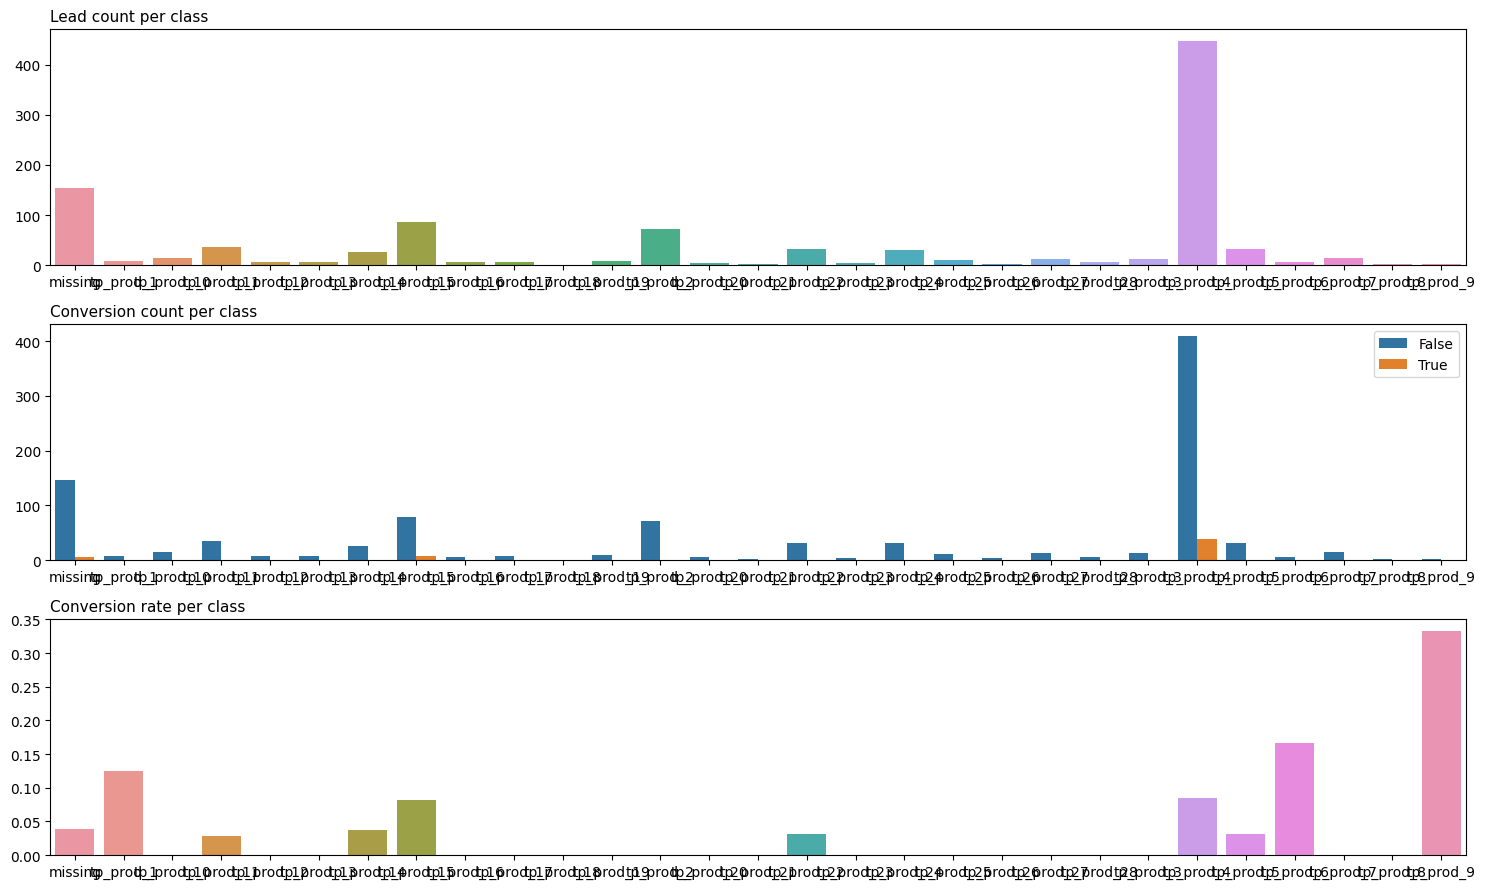

In [100]:
cat_feature_analysis_horizontal(quotes, 'product_third_party',missing_class=True)

---

- Le produit 4 est proposé dans 42% des cas. Le autres produits les plus proposé sont les produits 15(8%) et 2 (7%). Le reste des produits est à moins de 5%.
- Il y a également 15% de cas sans produits proposés.

On va dans un premier temps regroupé les produits à moins de 5% de fréquence car les résultats sont difficilement interprétables dans ces cas.

In [101]:
threshold = int(quotes.shape[0] *0.05)
cols = [prod for prod in quotes['product_third_party'].unique() if (quotes[quotes['product_third_party']==prod].shape[0]) < threshold and pd.notnull(prod)]
quotes.loc[quotes['product_third_party'].isin(cols),'product_third_party']= 'tp_prod_others'

Summary statistics: 
count           905
unique            4
top       tp_prod_4
freq            448
Name: product_third_party, dtype: object

Percentage of missing data: 14.46124763705104%

Conversion rate - missing data:  0.04

Conversion rate - non-missing:  0.06

Percentage of each discrete values: 
tp_prod_4         42.3
tp_prod_others    28.3
missing           14.5
tp_prod_15         8.1
tp_prod_2          6.8
Name: product_third_party, dtype: float64



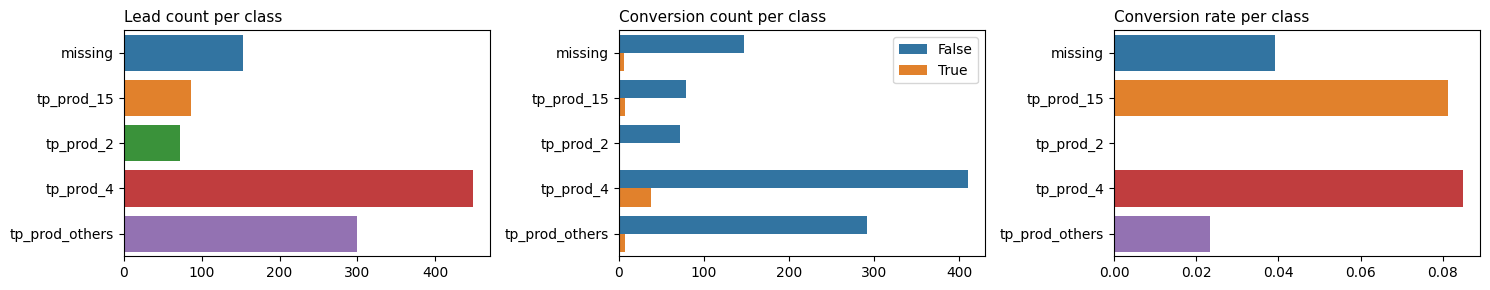

In [102]:
cat_feature_analysis(quotes, 'product_third_party',missing_class=True)

- Les devis des produits 15 et 4 ont un taux de conversion plus élevé que la moyenne.
- Les devis du produit 2 ne sont en revanche jamais convertis.
- Pour les autres produits le taux est assez bas
- Enfin pour les devis sans proposition de produit le taux de conversion est légérement en dessous de la moyenne.

---

### product_intermediate

Produit intermédiaire proposé

In [103]:
# Simplifions les noms de catégorie pour les graphiques
quotes['product_intermediate'] = quotes['product_intermediate'].str.replace('intermdiate_product','int_prod')

Comme pour la variable précédente, on va dans un premier temps regroupé les produits à moins de 5% de fréquence.

In [104]:
threshold = int(quotes.shape[0] *0.05)
cols = [prod for prod in quotes['product_intermediate'].unique() if (quotes[quotes['product_intermediate']==prod].shape[0]) < threshold and pd.notnull(prod)]
quotes.loc[quotes['product_intermediate'].isin(cols),'product_intermediate']= 'int_prod_others'

Summary statistics: 
count            905
unique             4
top       int_prod_5
freq             455
Name: product_intermediate, dtype: object

Percentage of missing data: 14.46124763705104%

Conversion rate - missing data:  0.04

Conversion rate - non-missing:  0.06

Percentage of each discrete values: 
int_prod_5         43.0
int_prod_others    28.9
missing            14.5
int_prod_14         6.8
int_prod_3          6.8
Name: product_intermediate, dtype: float64



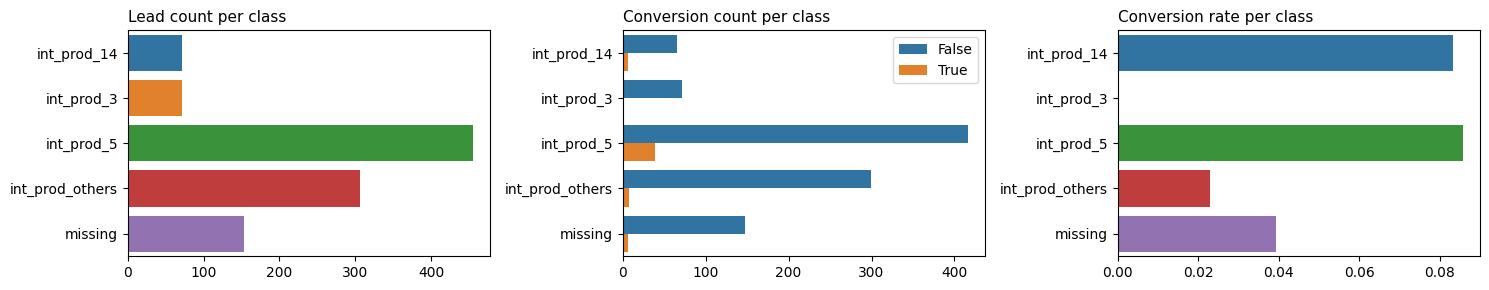

In [105]:
cat_feature_analysis(quotes, 'product_intermediate',missing_class=True)

- Le produit 5 est proposé dans 43% des cas. Les autres produits les plus proposés sont les produits 14 et 3 (7%). Il y a 15% de devis sans proposition de produit.
- Les devis des produits 5 et 14 ont un taux de conversion plus élevé que la moyenne.
- Les devis du produit 3 ne sont en revanche jamais convertis.
- Pour les autres produits le taux est assez bas
- Enfin pour les devis sans proposition de produit le taux de conversion est légérement en dessous de la moyenne.

---

### product_all_risks

Produit tous risques proposé

In [106]:
# Simplifions les noms de catégorie pour les graphiques
quotes['product_all_risks'] = quotes['product_all_risks'].str.replace('all_risks_product','all_prod')

Comme pour la variable précédente, on va dans un premier temps regroupé les produits à moins de 5% de fréquence.

In [107]:
threshold = int(quotes.shape[0] *0.05)
cols = [prod for prod in quotes['product_all_risks'].unique() if (quotes[quotes['product_all_risks']==prod].shape[0]) < threshold and pd.notnull(prod)]
quotes.loc[quotes['product_all_risks'].isin(cols),'product_all_risks']= 'all_prod_others'

Summary statistics: 
count            900
unique             4
top       all_prod_5
freq             458
Name: product_all_risks, dtype: object

Percentage of missing data: 14.933837429111533%

Conversion rate - missing data:  0.04

Conversion rate - non-missing:  0.06

Percentage of each discrete values: 
all_prod_5         43.3
all_prod_others    27.7
missing            14.9
all_prod_9          7.3
all_prod_3          6.8
Name: product_all_risks, dtype: float64



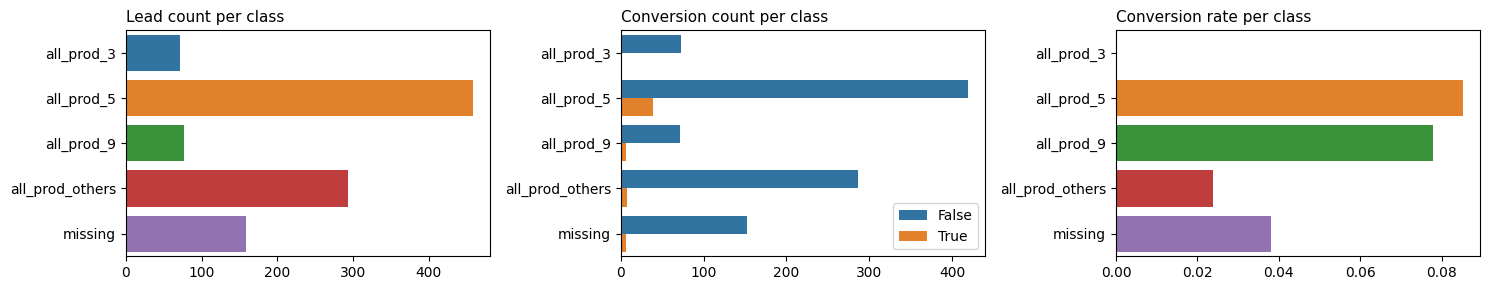

In [108]:
cat_feature_analysis(quotes, 'product_all_risks',missing_class=True)

- Le produit 5 est proposé dans 43% des cas. Les autres produits les plus proposés sont les produits 9 et 3 (7%). Il y a 15% de devis sans proposition de produit.
- Les devis des produits 5 et 9 ont un taux de conversion plus élevé que la moyenne.
- Les devis du produit 3 ne sont en revanche jamais convertis.
- Pour les autres produits le taux est assez bas
- Enfin pour les devis sans proposition de produit le taux de conversion est légérement en dessous de la moyenne.

Le constat est globalement le même pour les 3 catégories. Voyons voir les combinaisons de produits proposés.

In [109]:
pd.crosstab(quotes['product_all_risks'], quotes['product_intermediate'])

product_intermediate  int_prod_14  int_prod_3  int_prod_5  int_prod_others
product_all_risks                                                         
all_prod_3                      0          72           0                0
all_prod_5                      0           0         455                3
all_prod_9                     71           0           0                6
all_prod_others                 1           0           0              292

In [110]:
pd.crosstab(quotes['product_third_party'], quotes['product_intermediate'])

product_intermediate  int_prod_14  int_prod_3  int_prod_5  int_prod_others
product_third_party                                                       
tp_prod_15                     72           0           6                8
tp_prod_2                       0          72           0                0
tp_prod_4                       0           0         447                1
tp_prod_others                  0           0           2              297

On peut clairement voir qu'il y a des gammes de produits proposés:

- Gamme 1 : 15 - 14 - 9
- Gamme 2 : 2 - 3 - 3
- Gamme 3 : 4 - 5 - 5

Il n'y a donc probablement pas necessité d'utiliser ces 3 variables mais seulement une variable pour la gamme

---

### chosen_product

Produit correspondant à la formule sur laquelle le lead a cliqué

On va se concentrer sur les produit des gammes principales identifiées précédemment.

In [111]:
products = ['third_party_product_15','third_party_product_2', 'third_party_product_4', 
            'intermdiate_product_14', 'intermdiate_product_3', 'intermdiate_product_5',
            'all_risks_product_9', 'all_risks_product_3', 'all_risks_product_5']

Summary statistics: 
count        246
unique        10
top       others
freq          74
Name: chosen_product, dtype: object

Percentage of missing data: 76.74858223062382%

Conversion rate - missing data:  0.03

Conversion rate - non-missing:  0.13

Percentage of each discrete values: 
missing                   76.7
others                     7.0
third_party_product_4      5.6
all_risks_product_5        4.0
intermdiate_product_5      3.8
third_party_product_15     1.4
intermdiate_product_14     0.6
third_party_product_2      0.3
all_risks_product_3        0.3
intermdiate_product_3      0.2
all_risks_product_9        0.2
Name: chosen_product, dtype: float64



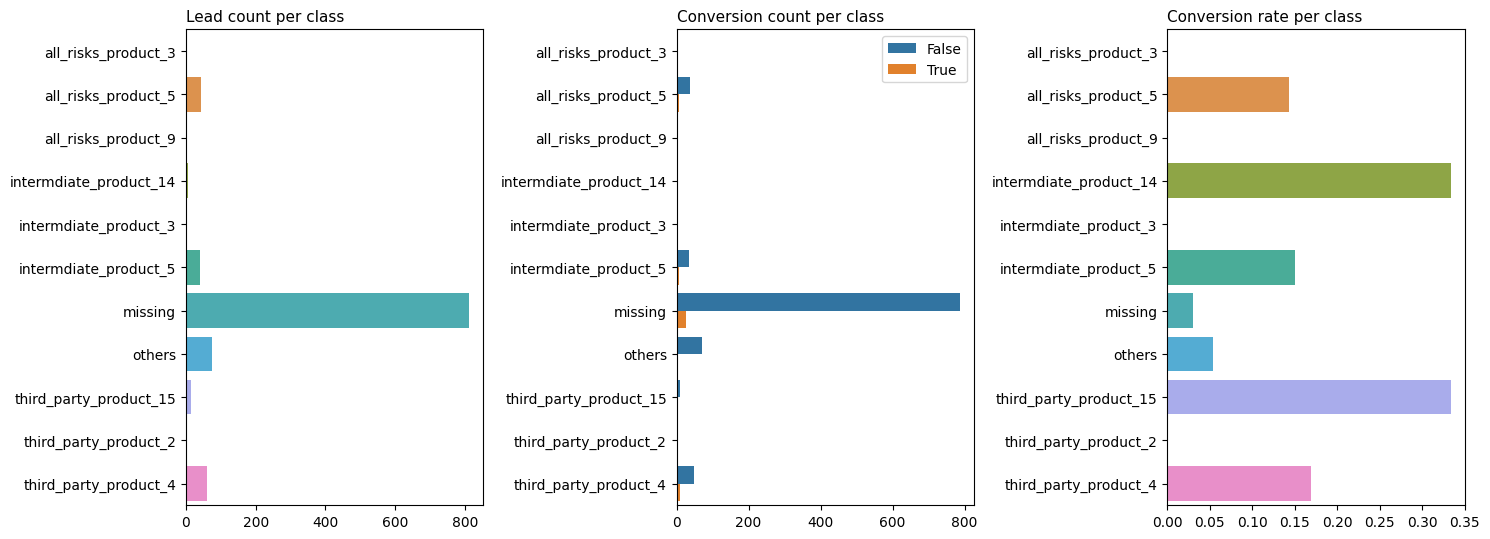

In [112]:
# quotes.loc[(~quotes['chosen_product'].isin(cols)) & (quotes['chosen_product'].notnull()),'chosen_product']= 'others'
quotes.loc[(~quotes['chosen_product'].isin(products)) & (quotes['chosen_product'].notnull()),'chosen_product']= 'others'
cat_feature_analysis(quotes, 'chosen_product',missing_class=True)

Les volumes par produit sont trop faibles pour tirer des conclusions fiables. On se contentera d'utiliser le champ `chosen_formula`

---

### vehicle_region

Région de parking du véhicule du lead

Visualison les données sur des cartes pour observer d'éventuelles aggrégations possibles.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
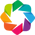

In [113]:
import geoviews as gv
import geoviews.feature as gf
import geopandas as gpd
from cartopy import crs
from geoviews import dim

gv.extension('bokeh')

In [114]:
# chargement des données géographiques par région
regions = gpd.read_file('regions-avant-redecoupage-2015.geojson')

In [115]:
new_name = {
    'Franche-Comté': 'Franche-Comte',
    'Midi-Pyrénées':'Midi-Pyrenees',
    'Nord-Pas-de-Calais':'Nord-Pas-De-Calais',
    'Pays de la Loire':'Pays De La Loire',
    "Provence-Alpes-Côte d'Azur": "Provence-Alpes-Cote D'azur",
    'Rhône-Alpes':'Rhone-Alpes',
    'Île-de-France': 'Ile-De-France'
}

# fusion des données
regions['nom'].replace(new_name, inplace=True)
region_stats = quotes.groupby('vehicle_region').agg({'lead_id':'count', 'has_subscribed': ['sum','mean']}).droplevel(axis=1, level=0).reset_index()
region_stats.columns = ['nom','nb_leads','nb_contracts', 'conversion_rate']
regions = regions.merge(region_stats, on='nom')
regions['conversion_rate'] = regions['conversion_rate'].round(3)*100
regions.head()

nom code                                           geometry  \
0      Ile-De-France   11  POLYGON ((2.59052 49.07966, 2.60913 49.09156, ...   
1  Champagne-Ardenne   21  POLYGON ((4.04797 49.40564, 4.04913 49.40901, ...   
2           Picardie   22  POLYGON ((3.48519 48.85191, 3.48016 48.85160, ...   
3    Haute-Normandie   23  POLYGON ((0.81482 48.67017, 0.81018 48.67135, ...   
4             Centre   24  POLYGON ((2.28105 46.42041, 2.27628 46.42128, ...   

   nb_leads  nb_contracts  conversion_rate  
0       217            12              5.5  
1        20             3             15.0  
2        31             3              9.7  
3        23             0              0.0  
4        31             2              6.5

In [116]:
# définition de la carte
map_reg = gv.Polygons(data = regions, vdims=["nb_leads", "conversion_rate", 'nb_contracts', "nom"])

In [117]:
# Carte des nb de leads
map_reg.opts(width=700, height=500, toolbar='above', color=dim('nb_leads'), title="Nombre de leads par région",
          colorbar=True, tools=['hover'], aspect='equal')

:Polygons   [Longitude,Latitude]   (nb_leads,conversion_rate,nb_contracts,nom)

In [118]:
renderer = gv.renderer('bokeh')
renderer.save(map_reg, 'map_leads')

In [119]:
# Carte des taux de conversion
map_reg.opts(width=700, height=500, toolbar='above', color=dim('conversion_rate'),title="Taux de conversion par région",
          colorbar=True, tools=['hover'], aspect='equal')

:Polygons   [Longitude,Latitude]   (nb_leads,conversion_rate,nb_contracts,nom)

In [120]:
renderer.save(map_reg, 'map_rates')

Essayons un regroupement geographique en fonction des taux observés et des populations

In [121]:
region_agg = {
'Alsace':'Est',
'Lorraine':'Est',
'Bourgogne':'Bourgogne/Franche-Comte',
'Franche-Comte':'Bourgogne/Franche-Comte',
'Haute-Normandie':'Normandie-Bretagne',
'Basse-Normandie':'Normandie-Bretagne', 
'Bretagne':'Normandie-Bretagne', 
'Pays De La Loire':'Centre-Ouest',
'Poitou-Charentes':'Centre-Ouest',
'Centre':'Centre-Ouest',
'Limousin':'Centre-Ouest',
'Auvergne':'Centre-Ouest',
'Midi-Pyrenees': 'Pyrenees - Languedoc',
'Languedoc-Roussillon': 'Pyrenees - Languedoc',
'Champagne-Ardenne':'Est',
'Picardie':'Nord',
'Nord-Pas-De-Calais':'Nord',
}

# regroupement des régions
regions['agg_region'] = regions['nom'].replace(region_agg)
regions_agg = regions.dissolve(by='agg_region', aggfunc='sum').reset_index()
regions_agg['conversion_rate'] = (regions_agg['nb_contracts'] / regions_agg['nb_leads']).round(3)*100
regions_agg

C:\Users\paulr\Documents\Boulot\ornikar_test\venv\lib\site-packages\geopandas\geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


agg_region  \
0                    Aquitaine   
1      Bourgogne/Franche-Comte   
2                 Centre-Ouest   
3                        Corse   
4                          Est   
5                Ile-De-France   
6                         Nord   
7           Normandie-Bretagne   
8   Provence-Alpes-Cote D'azur   
9         Pyrenees - Languedoc   
10                 Rhone-Alpes   

                                             geometry  nb_leads  nb_contracts  \
0   MULTIPOLYGON (((1.43302 45.01077, 1.40913 45.0...        59             7   
1   POLYGON ((6.93751 47.40668, 6.92239 47.40550, ...        42             0   
2   MULTIPOLYGON (((2.04085 44.98198, 2.00827 44.9...       134            10   
3   MULTIPOLYGON (((9.25360 41.36970, 9.25912 41.3...         4             0   
4   POLYGON ((7.67108 49.04597, 7.69173 49.04922, ...        85             6   
5   POLYGON ((2.59052 49.07966, 2.60913 49.09156, ...       217            12   
6   POLYGON ((3.48016 48.85160, 3.47020 48.85055, ...       109             5   
7   MULTIPOLYGON (((-3.21543 47.37201, -3.20543 47...        99             1   
8   MULTIPOLYGON (((6.19528 42.98839, 6.19161 42.9...       117             8   
9   MULTIPOLYGON (((-0.12590 43.29930, -0.12222 43...        87             3   
10  POLYGON ((6.26057 45.12685, 6.25850 45.12365, ...       105             6   

    conversion_rate  
0              11.9  
1               0.0  
2               7.5  
3               0.0  
4               7.1  
5               5.5  
6               4.6  
7               1.0  
8               6.8  
9               3.4  
10              5.7

In [122]:
map_reg_agg = gv.Polygons(data = regions_agg, vdims=["nb_leads", "conversion_rate", 'nb_contracts', "agg_region"])
map_reg_agg.opts(width=700, height=500, toolbar='above', color=dim('nb_leads'), title="Nombre de leads par région",
          colorbar=True, tools=['hover'], aspect='equal')
renderer.save(map_reg_agg, 'map_leads_agg')

In [123]:
map_reg_agg = gv.Polygons(data = regions_agg, vdims=["nb_leads", "conversion_rate", 'nb_contracts', "agg_region"])
map_reg_agg.opts(width=700, height=500, toolbar='above', color=dim('conversion_rate'), title="Taux de conversion par région",
          colorbar=True, tools=['hover',''], aspect='equal')
renderer.save(map_reg_agg, 'map_rates_agg')

On peut distinguer différents niveaux de taux:
- Elevé: Aquitaine
- Plutôt elevé: Centre-Ouest, Est, PACA
- Moyen: Rhone-Alpes - IDF
- Bas: Nord - Languedoc
- Nul : Normandie Bretagne / Bourgogne-Franche Comte / Corse

On pourra également essayer de ne conserver que les régions avec plus de 5% de populations et d'aggréger les autres.

Summary statistics: 
count       1058
unique         6
top       others
freq         482
Name: vehicle_region, dtype: object

Percentage of missing data: 0.0%

Percentage of each discrete values: 
others                        45.6
Ile-De-France                 20.5
Provence-Alpes-Cote D'azur    11.1
Rhone-Alpes                    9.9
Nord-Pas-De-Calais             7.4
Aquitaine                      5.6
Name: vehicle_region, dtype: float64



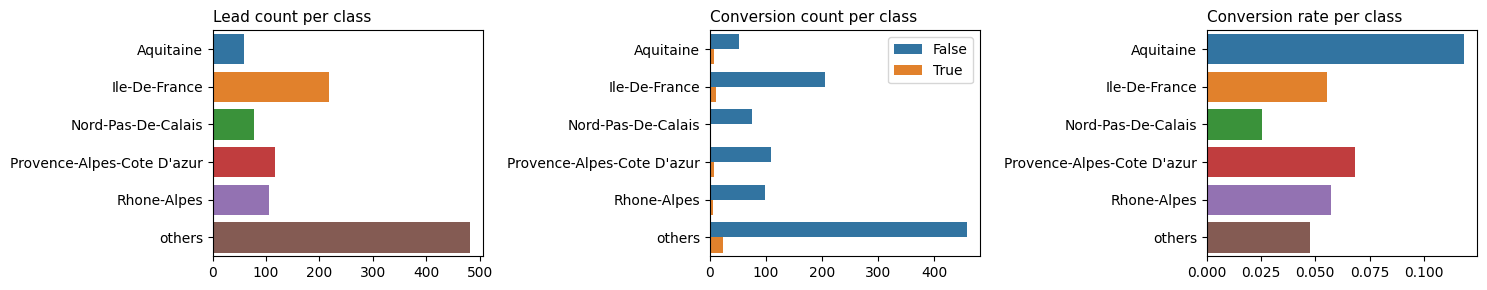

In [124]:
main_regions = ['Ile-De-France', "Provence-Alpes-Cote D'azur", 'Rhone-Alpes', 'Nord-Pas-De-Calais', 'Aquitaine']
quotes.loc[~quotes['vehicle_region'].isin(main_regions),'vehicle_region']= 'others'
cat_feature_analysis(quotes, 'vehicle_region',missing_class=True)

- Les leads sont principalement en Ile de France, Rhone-Alpes et PACA
- L'Ile de France et la région Rhone Alpes ont des taux de conversion moyen
- La région PACA a un taux légerement supérieur à la moyenne
- La région Aquitaine a un taux élevé de conversion
- Le Nord-Pas-De-Calais a un taux faible